In [1]:
# colors
# df_blank, '#', ''
# df_loaded, '#D5CAFF', '#601ef9'
# df_var1s, 'pink', 'lightpink'
# df_pz1, 'gold', 'orange'
# df_pz2, 'violet', 'fuchsia'

In [1]:
import re #regular expressions, used for searching strings in a systematic way
import cv2 #allows you to work with 
import plotly #basic image analysis/manipulation
import plotly.graph_objects as go #interavtive graphing
import numpy as np #array manipulation
import seaborn as sns #graphing tool
import matplotlib.pyplot as plt #graphing tool
from scipy.optimize import curve_fit #stats/data analysis
import math #bacis math functions
import os

#import helper functions 
from muser_mem_imaging_helper_functions import *

In [17]:
#uploading csv file and converting to a dataframe
with open('Z:/All_Staff/Grandl Lab/Michael Sindoni/mem_imaging_project/Pz1_Pz2_splice_expt/pz2_variant_tension_1.csv', 'r') as fhand:
# with open('C:/Users/msind/OneDrive/Desktop/Muser_2023/multiple_patch_sample.csv', 'r') as fhand:
# with open('D:/tension_expt_2023_06/weekend_2023_07_08/pz2_variant_tension.csv', 'r') as fhand:
    df_piezos = pd.read_csv(fhand)

In [18]:
#loading in all datafranes and triaging the data
df_pz1=df_piezos.loc[(df_piezos['category']=='hPz1') & (df_piezos['tension']<12) & (df_piezos['p50_avg_max_current']>30) & (df_piezos['percent_std_error_rad']<=10)]
df_pz2=df_piezos.loc[(df_piezos['category']=='hPz2') & (df_piezos['tension']<12) & (df_piezos['p50_avg_max_current']>30) & (df_piezos['percent_std_error_rad']<=10)]
df_blank=df_piezos.loc[(df_piezos['category']=='blank') & (df_piezos['tension']<12) & (df_piezos['p50_avg_max_current']>30) & (df_piezos['percent_std_error_rad']<=10)]
df_loaded=df_piezos.loc[(df_piezos['category']=='loaded') & (df_piezos['tension']<12) & (df_piezos['p50_avg_max_current']>30) & (df_piezos['percent_std_error_rad']<=10)]
df_var1s=df_piezos.loc[(df_piezos['category']=='var1s') & (df_piezos['tension']<12) & (df_piezos['p50_avg_max_current']>30) & (df_piezos['percent_std_error_rad']<=10)]


In [24]:
def generate_p50_norm(df_summary):
    '''Takes the summary df generated originally from the max_currents function and performs a P50 fit on the normalized data. The fit is constrained to +/-30pA of the max current.
     This data, along with the max current determined by the plateau of the fit, are then added to the summary dataframe (df_summary).
     
     Inputs:
        -df_summary: summary dataframe originally generated from the max_currents function.

    Outputs:
        -df_summary: updated version of the inpur df_summary that now contains a p50 and p50_max_current column'''
    
    p50_list_avgm=[]
    k_avgm_slope_list=[]
    
    # #setting arbitrary upper and lower bounds to the fit is not constrained but its close to where the true plateau should be
    amin = df_summary['avg_norm_current'].max()-0.3
    amax = df_summary['avg_norm_current'].max()+0.3
    popt, pcov = curve_fit(fit_boltz, df_summary['pressure'], df_summary['avg_norm_current'],
                           bounds=([-np.inf, -np.inf, -np.inf], [np.inf, np.inf, np.inf]))

    #adding p50 and max from p50 values to respective lists with the same length as the number of pressure steps for that patch
    for i in range(len(df_summary)):
        p50_list_avgm.append(popt[1])
        k_avgm_slope_list.append(popt[2])

    #updating the summary dataframe to contain the p50 and max current determined by the plateau of the p50 fit
    df_summary['p50_avgm'] = p50_list_avgm
    df_summary['k_avgm_slope'] = k_avgm_slope_list

    #plotting the data as a visual check that the fit is reasonable
    xdata_gen = np.linspace(0, df_summary['pressure'].max(), 500)
    ydata_gen = fit_boltz(xdata_gen, *popt)
    print('P50 value from Boltzman Fit: ', popt[1], 'mmHg')
    print('k value from Boltzman Fit: ', popt[2])
    
    #plotting P50
    plt.scatter(df_summary['pressure'], df_summary['avg_norm_current'], color='orange',s=70, edgecolors='black', zorder=3)
    plt.plot(xdata_gen, ydata_gen, linewidth=5, color='blue', zorder=2)

    #plotting lines to show P50 value
    plt.plot([0, popt[1]], [0.5, 0.5], linewidth=5, color='red', linestyle='dotted', zorder=1)
    plt.plot([popt[1], popt[1]], [0, 0.5], linewidth=5, color='red', linestyle='dotted', zorder=1)
    plt.scatter(popt[1], 0.5, color='red', s=100, edgecolors='black', zorder=4)
    plt.ylabel('Normalized Current') #add y axis title
    plt.xlabel('Pressure (mmHg)') #add x axis title
    plt.show()

    #repeating this process for the mabolute max current values
    p50_list_absm=[]
    k_absm_slope_list=[]

    #setting arbitrary upper and lower bounds to the fit is not constrained but its close to where the true plateau should be
    amin = df_summary['abs_norm_current'].max()-0.2
    amax = df_summary['abs_norm_current'].max()+0.2
    popt, pcov = curve_fit(fit_boltz, df_summary['pressure'], df_summary['abs_norm_current'],
                           bounds=([amin, -np.inf, -np.inf], [amax, np.inf, np.inf]))
    
    #adding p50 and max from p50 values to respective lists with the same length as the number of pressure steps for that patch
    for i in range(len(df_summary)):
        p50_list_absm.append(popt[1])
        k_absm_slope_list.append(popt[2])

    #updating the summary dataframe to contain the p50 and max current determined by the plateau of the p50 fit
    df_summary['p50_absm'] = p50_list_absm
    df_summary['k_absm_slope'] = k_absm_slope_list

    return df_summary

P50 21.91262409901368
k 0.10160075117615189
P50 Std 1.419886027162228
k std 0.007760428922978266


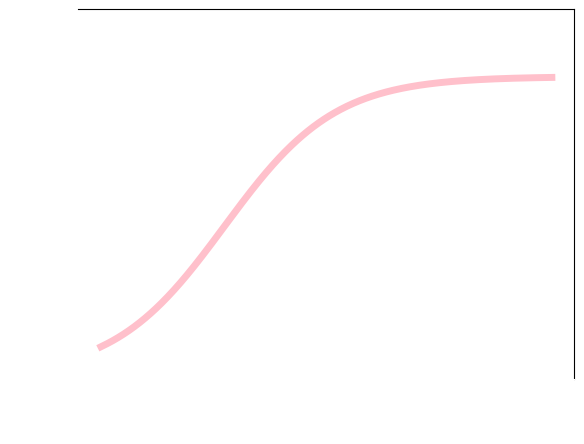

In [73]:
# colors
# df_blank, '#', ''
# df_loaded, '#D5CAFF', '#601ef9'
# df_var1s, '#'lavenderblush', 'lightpink'
# df_pz1, 'gold', 'orange'
# df_pz2, 'violet', 'fuchsia'

p50_error_fig=p50_error_plot(df_var1s, 'pink')
construct='var1s'
p50_error_fig.savefig('Z:/All_Staff/Grandl Lab/Michael Sindoni/mem_imaging_project/tension_expt_2023_06/analyzed_data_figures_updated/p50_basic_'+construct+'.png', transparent=True,  bbox_inches='tight', dpi=1000)


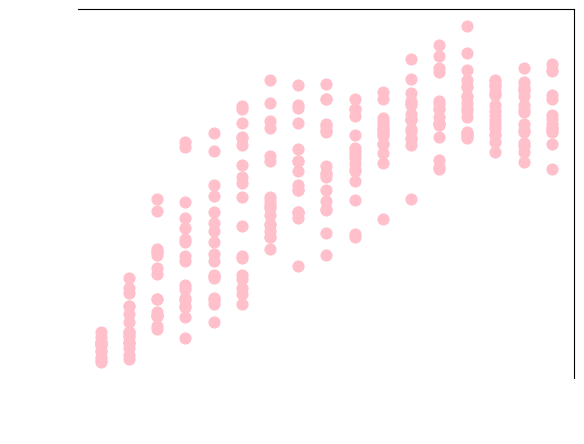

In [71]:
# colors
# df_blank, '#', ''
# df_loaded, '#D5CAFF', '#601ef9'
# df_var1s, 'pink', 'lightpink'
# df_pz1, 'gold', 'orange'
# df_pz2, 'violet', 'fuchsia'

basic_pressure_scatter_fig=basic_pressure_scatter(df_var1s, 'pink')
construct='var1s'
# basic_pressure_scatter_fig.savefig('Z:/All_Staff/Grandl Lab/Michael Sindoni/mem_imaging_project/tension_expt_2023_06/analyzed_data_figures_updated/basic_pressure_scatter_'+construct+'.png', transparent=True,  bbox_inches='tight', dpi=1000)
basic_pressure_scatter_fig.savefig('Z:/All_Staff/Grandl Lab/Michael Sindoni/mem_imaging_project/tension_expt_2023_06/analyzed_data_figures_updated/basic_pressure_scatter_'+construct+'.png', transparent=True,  bbox_inches='tight', dpi=1200)


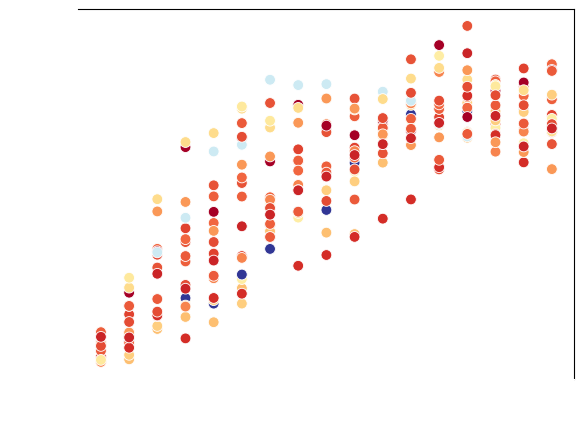

In [76]:
max_current_hue_pressure_scatter_fig=max_current_hue_pressure_scatter(df_var1s)
construct='var1s'
max_current_hue_pressure_scatter_fig.savefig('Z:/All_Staff/Grandl Lab/Michael Sindoni/mem_imaging_project/tension_expt_2023_06/analyzed_data_figures_updated/max_current_hue_pressure_scatter_'+construct+'.png', transparent=True,  bbox_inches='tight', dpi=1000)


           date  number
110  2023_06_12      34
118  2023_06_12      36
176  2023_06_13      18
191  2023_06_13      20
328  2023_06_14      20
346  2023_06_14      21
360  2023_06_14      22
470  2023_06_15      22
485  2023_06_15      25
551  2023_06_23      24
566  2023_06_23      26
640  2023_06_27      29
658  2023_06_27      31
751  2023_06_29      18
768  2023_06_29      20
785  2023_06_29      22
802  2023_06_29      25
n =  17


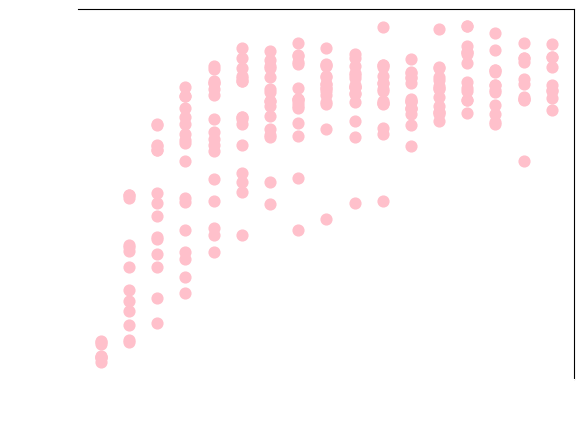

In [39]:
construct='var1s'
cutoff_i=20
basic_pressure_scatter_cutoff_fig=basic_pressure_scatter_cutoff(df_loaded, 'pink', cutoff_i)
# basic_pressure_scatter_cutoff_fig.savefig('Z:/All_Staff/Grandl Lab/Michael Sindoni/mem_imaging_project/tension_expt_2023_06/analyzed_data_figures_updated/basic_pressure_scatter_cutoff_'+construct+'_'+str(cutoff_i)+'.png', transparent=True,  bbox_inches='tight', dpi=1000)


P50 22.27286050525998
k 0.11085698345969665
P50 Std 1.9780563819154127
k std 0.011261021950716895


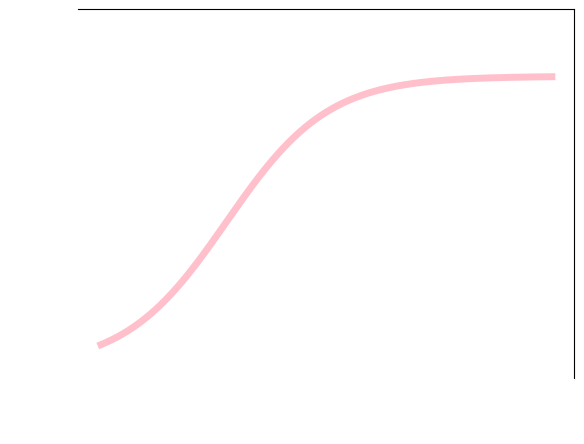

In [89]:
construct='var1s'
cutoff_i=50
p50_error_current_cutoff_fig=p50_error_current_cutoff(df_var1s, 'pink', 50)
p50_error_current_cutoff_fig.savefig('Z:/All_Staff/Grandl Lab/Michael Sindoni/mem_imaging_project/tension_expt_2023_06/analyzed_data_figures_updated/p50_error_current_cutoff_'+construct+'_'+str(cutoff_i)+'.png', transparent=True,  bbox_inches='tight', dpi=1000)


In [166]:
#weighting p50 fit based on pressure spread

def t50_error_plot(df, linecolor):
    tension_list=[]
    avg_i_list=[]
    std_list=[]
    pressure_marker=0
    floor=0
    ceiling=0.5

    max_tension=math.ceil(df['tension'].max())

    for i in range(max_tension-2):
        if i == 0:
            df_tension_range=df.loc[(df['tension']>=floor) & (df['tension']<ceiling)]
            tension_list.append(pressure_marker)
            avg_i_list.append(df_tension_range['avg_norm_current'].mean())
            std_list.append(df_tension_range['avg_norm_current'].std())
            pressure_marker+=1
            floor+=0.5
            ceiling+=1
        else:
            df_tension_range=df.loc[(df['tension']>=floor) & (df['tension']<ceiling)]
            tension_list.append(pressure_marker)
            avg_i_list.append(df_tension_range['avg_norm_current'].mean())
            std_list.append(df_tension_range['avg_norm_current'].std())
            pressure_marker+=1
            floor+=1
            ceiling+=1

    amin = df_tension_range['avg_norm_current'].iloc[0]-0.3
    amax = df_tension_range['avg_norm_current'].iloc[0]+0.3

    popt, pcov = curve_fit(fit_boltz, tension_list, avg_i_list, sigma=std_list, p0=[1, 4, 0.6],
                          bounds=([amin, -np.inf, -np.inf], [amax, np.inf, np.inf]))

    xdata=np.linspace(0,max_tension,500)
    ydata=fit_boltz(xdata, *popt)

    p50_std=np.sqrt(pcov[1,1])
    k_std=np.sqrt(pcov[2,2])


    print('P50', popt[1])
    print('k', popt[2])
    print('P50 Std',p50_std)
    print('k std',k_std)

    # Create a figure and axis object
    fig, ax = plt.subplots()

    # Plot the scatter of pressure vs. average normalized current
    ax.errorbar(tension_list, avg_i_list, yerr=std_list, color='white', zorder=1, fmt='o')

    # Plot the fitted curve
    ax.plot(xdata, ydata, color=linecolor, linewidth=5, zorder=2)

    # Set the labels and tick parameters
    ax.set_xlabel('Tension (mN/m)', fontsize=15, color='white')
    ax.set_ylabel('Normalized Current', fontsize=15, color='white')
    ax.tick_params(axis='both', labelsize=15, color='white')

    ax.tick_params(axis='x', colors='white') 
    ax.tick_params(axis='y', colors='white') 
    ax.spines['bottom'].set_color('white')
    ax.spines['left'].set_color('white')

    return fig

P50 3.6052683849266858
k 0.9140487515733563
P50 Std 0.28254077588987647
k std 0.08007065108840031


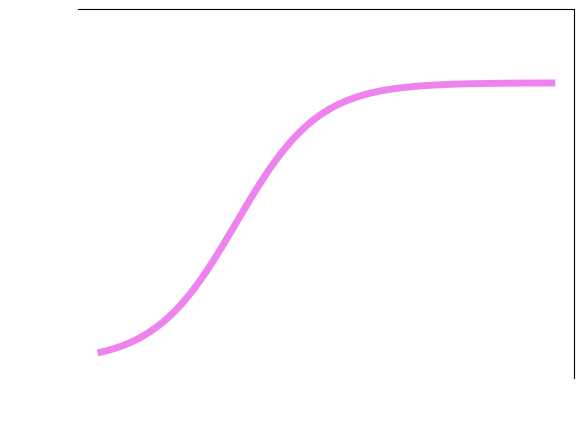

In [167]:
# colors
# df_blank, '#', ''
# df_loaded, '#D5CAFF', '#601ef9'
# df_var1s, '#'lavenderblush', 'lightpink'
# df_pz1, 'gold', 'orange'
# df_pz2, 'violet', 'fuchsia'

t50_error_plot_fig=t50_error_plot(df_pz2, 'violet')
construct='hPz2'
t50_error_plot_fig.savefig('Z:/All_Staff/Grandl Lab/Michael Sindoni/mem_imaging_project/tension_expt_2023_06/analyzed_data_figures_updated/t50_error_plot_'+construct+'.png', transparent=True,  bbox_inches='tight', dpi=1000)


In [5]:
#FOR R01

def t50_std_plot_r01(df_list, linecolor_list):
    # Create a figure and axis object
    fig, ax = plt.subplots()
    
    for i in range(len(df_list)):
        df=df_list[i]
        linecolor=linecolor_list[i]
        tension_list=[]
        avg_i_list=[]
        std_list=[]
        pressure_marker=0
        floor=0
        ceiling=0.5

        max_tension=math.ceil(df['tension'].max())

        for i in range(max_tension-2):
            if i == 0:
                df_tension_range=df.loc[(df['tension']>=floor) & (df['tension']<ceiling)]
                tension_list.append(pressure_marker)
                avg_i_list.append(df_tension_range['avg_norm_current'].mean())
                std_list.append(df_tension_range['avg_norm_current'].std())
                pressure_marker+=1
                floor+=0.5
                ceiling+=1
            else:
                df_tension_range=df.loc[(df['tension']>=floor) & (df['tension']<ceiling)]
                tension_list.append(pressure_marker)
                avg_i_list.append(df_tension_range['avg_norm_current'].mean())
                std_list.append(df_tension_range['avg_norm_current'].std())
                pressure_marker+=1
                floor+=1
                ceiling+=1

        amin = df_tension_range['avg_norm_current'].iloc[0]-0.3
        amax = df_tension_range['avg_norm_current'].iloc[0]+0.3

        popt, pcov = curve_fit(fit_boltz, tension_list, avg_i_list, sigma=std_list, p0=[1, 4, 0.6],
                              bounds=([amin, -np.inf, -np.inf], [amax, np.inf, np.inf]))

        xdata=np.linspace(0,11,500)
        ydata=fit_boltz(xdata, *popt)

        p50_std=np.sqrt(pcov[1,1])
        k_std=np.sqrt(pcov[2,2])


        print('P50', popt[1])
        print('k', popt[2])
        print('P50 Std',p50_std)
        print('k std',k_std)

        # Plot the scatter of pressure vs. average normalized current
        ax.errorbar(tension_list, avg_i_list, yerr=std_list, color='black', zorder=1, fmt='o')

        # Plot the fitted curve
        ax.plot(xdata, ydata, color=linecolor, linewidth=5, zorder=2)

    # Set the labels and tick parameters
    ax.set_xlabel('Tension (mN/m)', fontsize=15, color='black')
    ax.set_ylabel('Normalized Current', fontsize=15, color='black')
    ax.tick_params(axis='both', labelsize=15, color='black')

    ax.tick_params(axis='x', colors='black') 
    ax.tick_params(axis='y', colors='black') 
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')

    return fig

P50 2.292855164827931
k 1.3477739532798674
P50 Std 0.12701759048654568
k std 0.12493437854911721
P50 3.6052683849266858
k 0.9140487515733563
P50 Std 0.28254077588987647
k std 0.08007065108840031


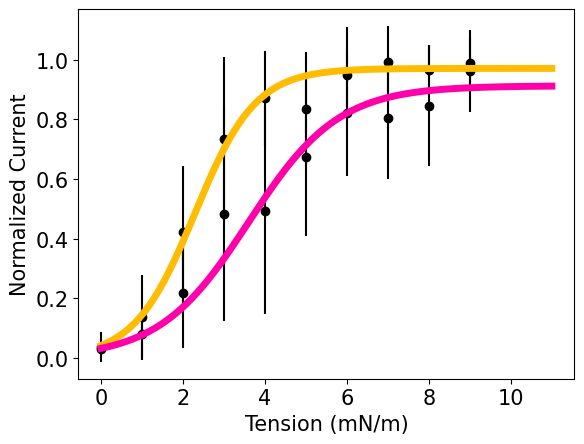

In [8]:
# colors
# df_blank, '#', ''
# df_loaded, '#D5CAFF', '#601ef9'
# df_var1s, '#'lavenderblush', 'lightpink'
# df_pz1, 'gold', 'orange'
# df_pz2, 'violet', 'fuchsia'

t50_std_plot_r01_fig=t50_std_plot_r01([df_pz1, df_pz2], ['#FFBC00', '#FF00AB'])
construct='hPz1'
# t50_error_plot_r01_fig.savefig('Z:/All_Staff/Grandl Lab/Michael Sindoni/mem_imaging_project/tension_expt_2023_06/analyzed_data_figures_updated/t50_std_plot_r01_'+construct+'.png', transparent=True,  bbox_inches='tight', dpi=1000)


P50 2.681460614817953
k 0.8674698236477627
P50 Std 0.24038396594584968
k std 0.07900270000859545
P50 1.2987069238208373
k 2.273442931568248
P50 Std 0.16817069378489524
k std 0.35682323220283313


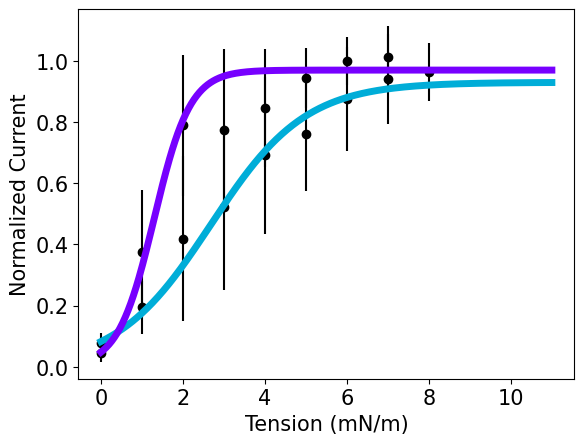

In [9]:
t50_std_plot_r01_fig=t50_std_plot_r01([df_var1s, df_loaded], ['#00ADD8', '#7700FF'])
construct='hPz1'
# t50_error_plot_r01_fig.savefig('Z:/All_Staff/Grandl Lab/Michael Sindoni/mem_imaging_project/tension_expt_2023_06/analyzed_data_figures_updated/t50_std_plot_r01_'+construct+'.png', transparent=True,  bbox_inches='tight', dpi=1000)


In [65]:
def t50_error_plot_r01(df_list, linecolor_list, label_name):
    # Create a figure and axis object
    fig, ax = plt.subplots(figsize=(20,20))
    for i in range(len(df_list)):
        df=df_list[i]
        label=label_name[i]
        linecolor=linecolor_list[i]
        tension_list=[]
        avg_i_list=[]
        std_list=[]
        std_error_list=[]
        pressure_marker=0
        floor=0
        ceiling=0.5

        max_tension=math.ceil(df['tension'].max())

        for i in range(max_tension-2):
            if i == 0:
                df_tension_range=df.loc[(df['tension']>=floor) & (df['tension']<ceiling)]
                tension_list.append(pressure_marker)
                avg_i_list.append(df_tension_range['avg_norm_current'].mean())
                std_list.append(df_tension_range['avg_norm_current'].std())
                std_error_list.append(df_tension_range['avg_norm_current'].std()/np.sqrt(len(df_tension_range)))
                print(len(df_tension_range))
                pressure_marker+=1
                floor+=0.5
                ceiling+=1
            else:
                df_tension_range=df.loc[(df['tension']>=floor) & (df['tension']<ceiling)]
                tension_list.append(pressure_marker)
                avg_i_list.append(df_tension_range['avg_norm_current'].mean())
                std_list.append(df_tension_range['avg_norm_current'].std())
                std_error_list.append(df_tension_range['avg_norm_current'].std()/np.sqrt(len(df_tension_range)))
                print(len(df_tension_range))
                pressure_marker+=1
                floor+=1
                ceiling+=1

        amin = df_tension_range['avg_norm_current'].iloc[0]-0.3
        amax = df_tension_range['avg_norm_current'].iloc[0]+0.3

        popt, pcov = curve_fit(fit_boltz, tension_list, avg_i_list, sigma=std_list, p0=[1, 4, 0.6],
                              bounds=([amin, -np.inf, -np.inf], [amax, np.inf, np.inf]))

        xdata=np.linspace(0,10.5,500)
        ydata=fit_boltz(xdata, *popt)

        p50_std=np.sqrt(pcov[1,1])
        k_std=np.sqrt(pcov[2,2])


        print('P50', popt[1])
        print('k', popt[2])
        print('P50 Std',p50_std)
        print('k std',k_std)

        # Plot the scatter of pressure vs. average normalized current
        ax.errorbar(tension_list, avg_i_list, yerr=std_error_list, zorder=2, fmt='o',
                    color=linecolor, ecolor='black', capsize=10, elinewidth=4, markersize=40, 
                    markeredgecolor='black', markeredgewidth=5, label=label)
       

        # Plot the fitted curve
        ax.plot(xdata, ydata, color='black', linewidth=3, zorder=1)

    # Set the labels and tick parameters
    ax.set_xlabel('Tension (mN/m)', fontsize=60, color='black')
    ax.set_ylabel('Normalized Current', fontsize=60, color='black')
    ax.tick_params(axis='both', labelsize=40, color='black')

    ax.tick_params(axis='x', colors='black')
    ax.tick_params(axis='y', colors='black')
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['top'].set_color('white')
    ax.spines['right'].set_color('white')
    ax.spines['bottom'].set_linewidth(2.0)
    ax.spines['left'].set_linewidth(2.0)
    ax.legend(frameon=False,fontsize=40, loc='lower right')

    return fig

10
15
24
27
31
29
27
23
7
6
P50 2.292855164827931
k 1.3477739532798674
P50 Std 0.12701759048654568
k std 0.12493437854911721
7
9
16
25
22
26
26
22
15
9
P50 3.6052683849266858
k 0.9140487515733563
P50 Std 0.28254077588987647
k std 0.08007065108840031


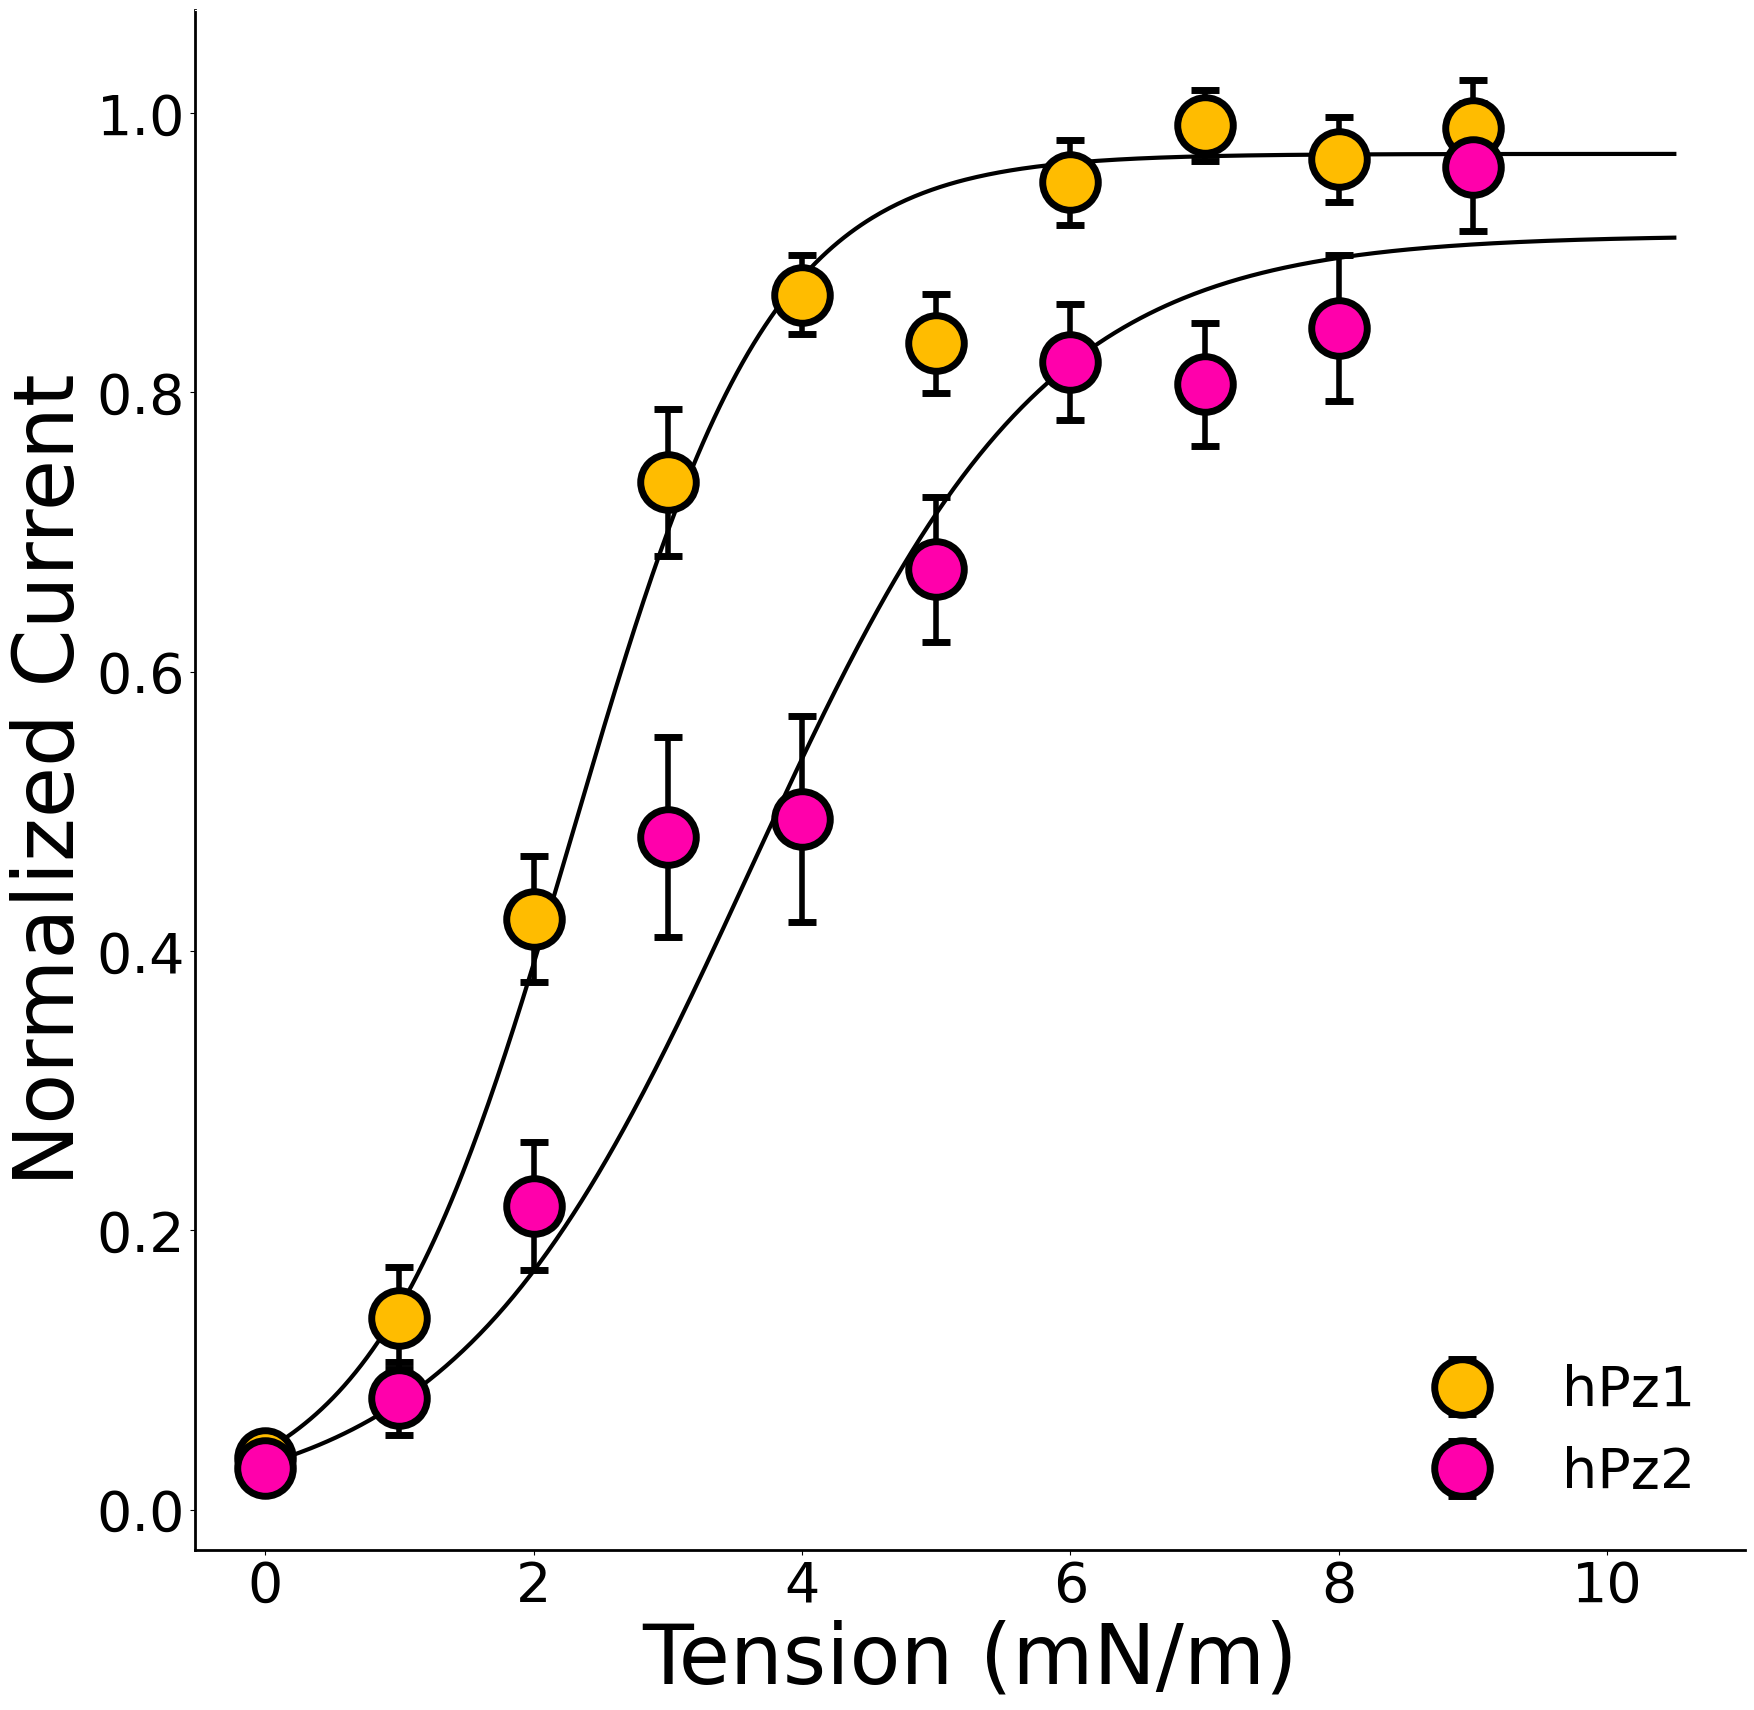

In [66]:
t50_error_plot_r01_fig=t50_error_plot_r01([df_pz1, df_pz2], ['#FFBC00', '#FF00AB'], ['hPz1', 'hPz2'])
construct='Pz1_Pz2'
t50_error_plot_r01_fig.savefig('C:/Users/mjs164/Box Sync/misc_old/retreat_2023/figures/t50_error_plot_r01_'+construct+'.png',  bbox_inches='tight', dpi=1200)


13
11
31
42
37
32
49
31
P50 2.681460614817953
k 0.8674698236477627
P50 Std 0.24038396594584968
k std 0.07900270000859545
8
16
32
33
37
31
28
24
22
P50 1.2987069238208373
k 2.273442931568248
P50 Std 0.16817069378489524
k std 0.35682323220283313


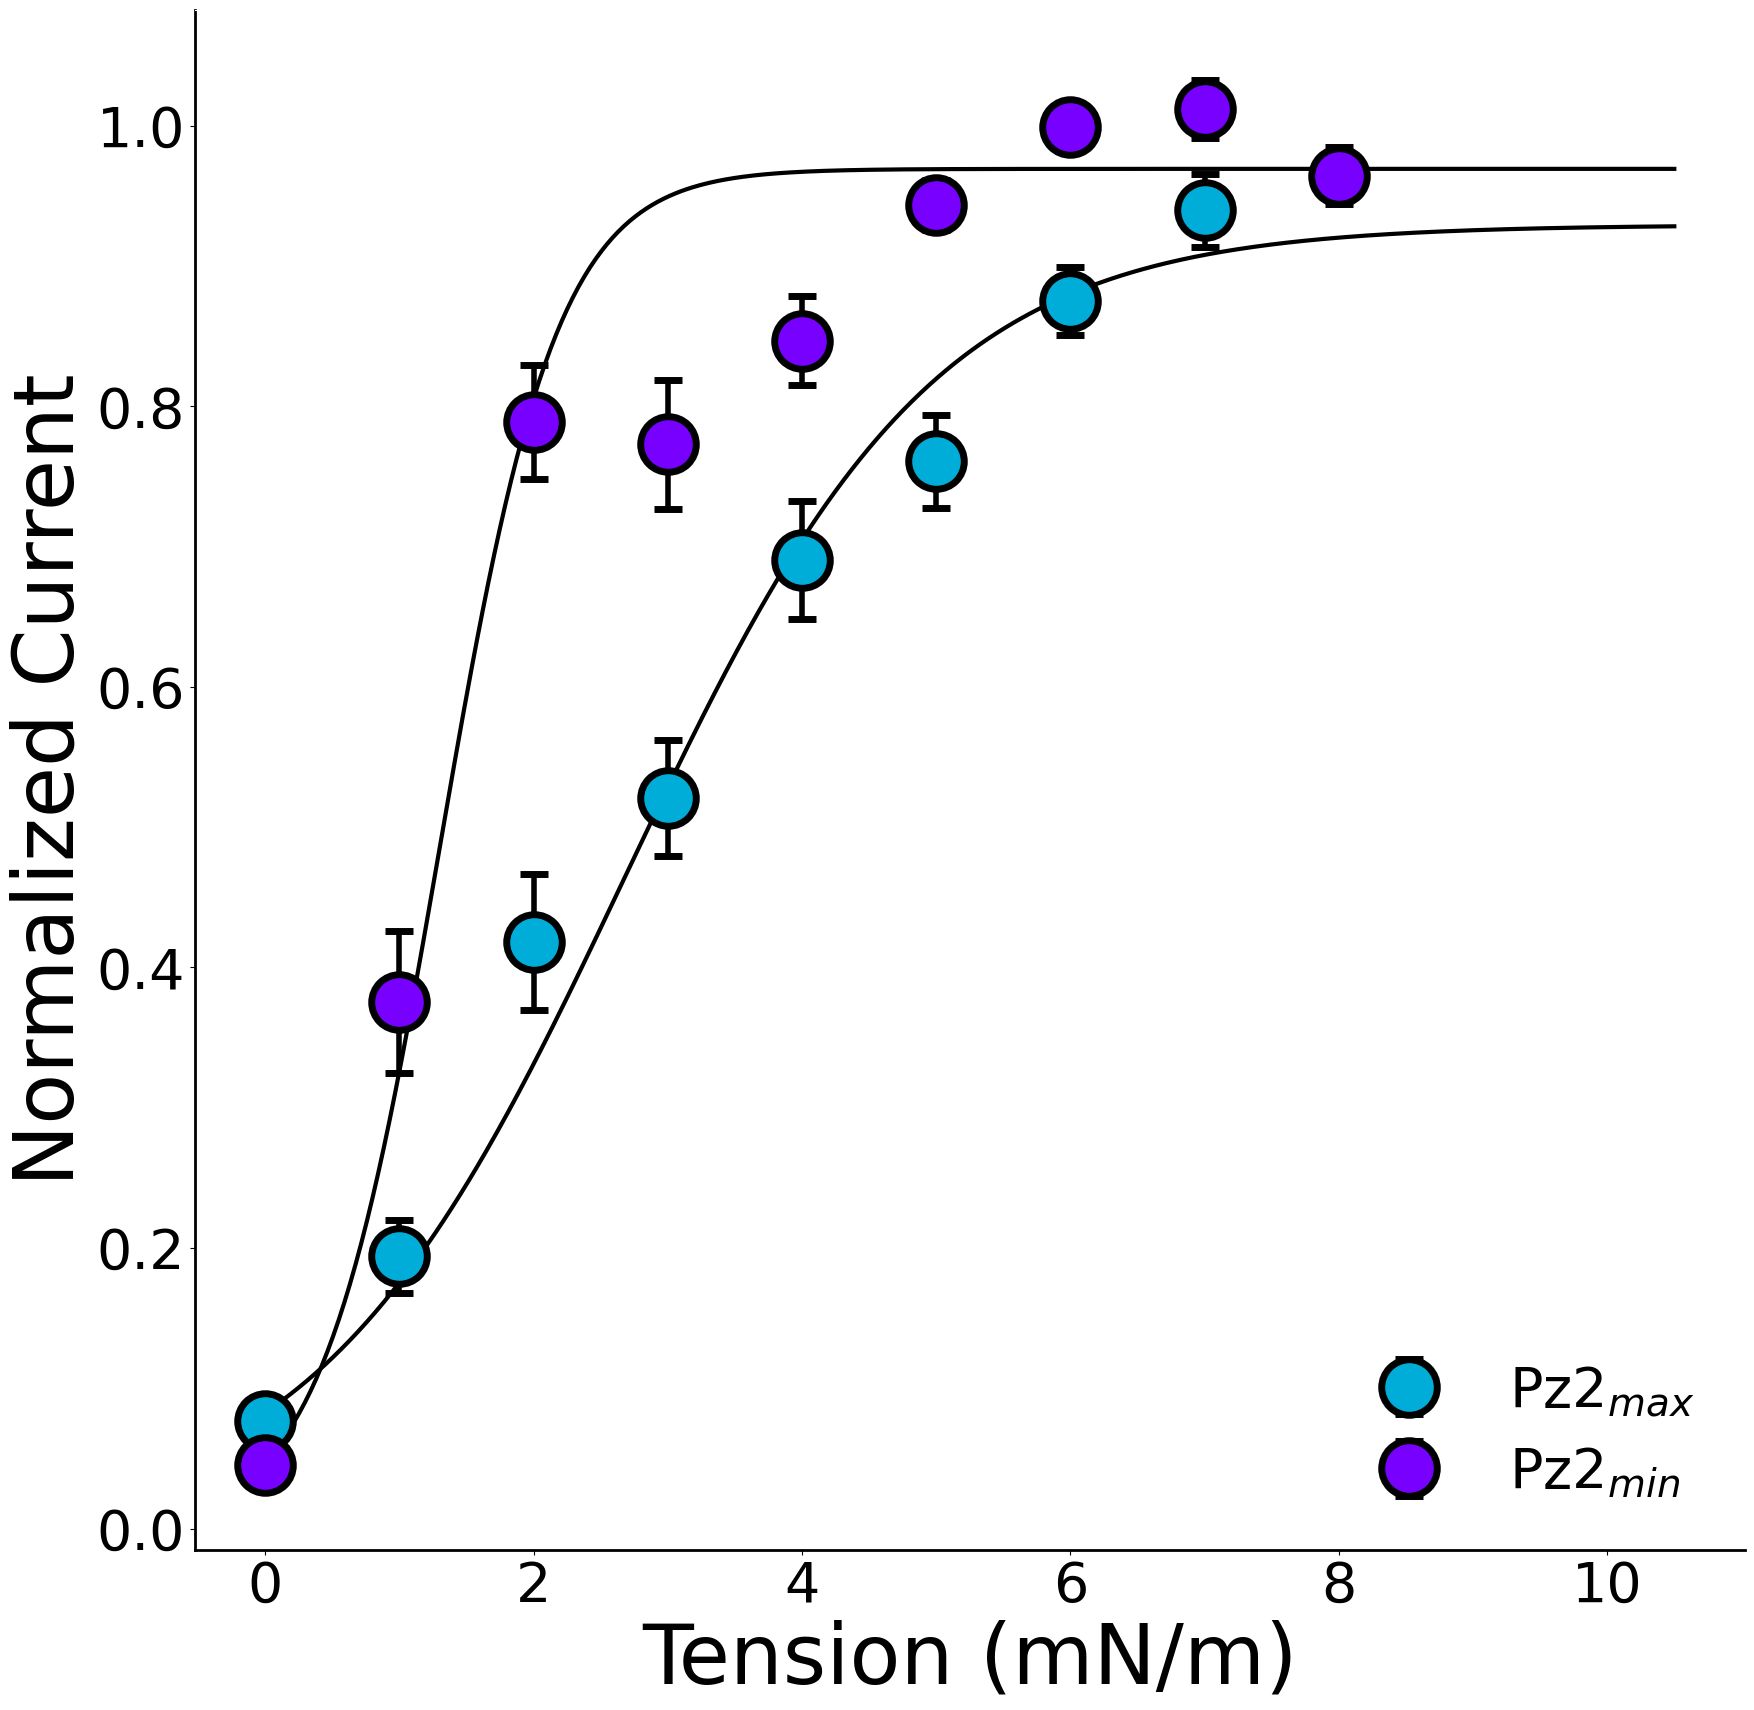

In [67]:
t50_error_plot_r01_fig=t50_error_plot_r01([df_var1s, df_loaded], ['#00ADD8', '#7700FF'], ['Pz2$_{max}$', 'Pz2$_{min}$'])
construct='Pz2max_Pz2min'
# t50_error_plot_r01_fig.savefig('Z:/All_Staff/Grandl Lab/Michael Sindoni/mem_imaging_project/tension_expt_2023_06/analyzed_data_figures_updated/t50_error_plot_r01_'+construct+'.png', transparent=True,  bbox_inches='tight', dpi=1000)
t50_error_plot_r01_fig.savefig('C:/Users/mjs164\Box Sync/misc_old/retreat_2023/figures/t50_error_plot_r01_'+construct+'.png',  bbox_inches='tight', dpi=1200)



<re.Match object; span=(0, 10), match='2023_06_12'>
2023_06_12
10
165.1594552
<re.Match object; span=(0, 10), match='2023_06_12'>
2023_06_12
11
104.7572478
<re.Match object; span=(0, 10), match='2023_06_12'>
2023_06_12
20
not in category list blank
<re.Match object; span=(0, 10), match='2023_06_12'>
2023_06_12
23
not in category list blank
<re.Match object; span=(0, 10), match='2023_06_12'>
2023_06_12
25
not in category list blank
<re.Match object; span=(0, 10), match='2023_06_12'>
2023_06_12
27
not present
<re.Match object; span=(0, 10), match='2023_06_12'>
2023_06_12
29
not present
<re.Match object; span=(0, 10), match='2023_06_12'>
2023_06_12
34
not in category list loaded
<re.Match object; span=(0, 10), match='2023_06_12'>
2023_06_12
36
not in category list loaded
<re.Match object; span=(0, 10), match='2023_06_12'>
2023_06_12
6
74.01673391
<re.Match object; span=(0, 10), match='2023_06_12'>
2023_06_12
7
71.28197642
<re.Match object; span=(0, 10), match='2023_06_13'>
2023_06_13
15
n

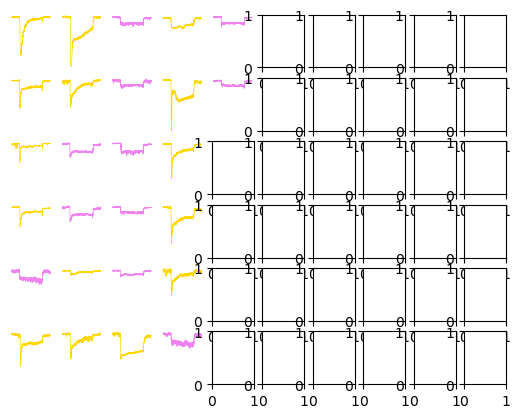

In [61]:
#generating traces figures
# date=
# number
# file=''

linecolor_dict= {'hPz1': 'gold', 'hPz2': 'violet'}
category_list=['hPz1', 'hPz2']

fig, ax=plt.subplots(6, 10)
column_count=0
row_count=0

directory = 'Z:/All_Staff/Grandl Lab/Michael Sindoni/mem_imaging_project/tension_expt_2023_06/ascii_files/done'
for filename in os.listdir(directory):
    
    #loading individual ascii files
    df_ephys = load_dataframe(directory+'/'+filename)
    
    #using regular expression to pull out date and number
    date_pattern = r"\d{4}_\d{2}_\d{2}"
    time_pattern = r"\d{1,2}(?=\.)"
    date_match = re.search(date_pattern, filename)
    time_match = re.search(time_pattern, filename)
    print(date_match)
    if date_match and time_match:
        date_part = date_match.group()
        time_part = time_match.group()
        print(date_part)
        print(time_part)
    else:
        print("No match found.")
        
    #determining last sweep number from summary data df
    max_sweep=df_piezos['sweep'].loc[(df_piezos['date']==date_part) & (df_piezos['number']==float(time_part))].max()
    
    #eliminates going through the loop for any raw ephys file that does not have a 
    #corresponding dat/number pain in the summary df
    if math.isnan(max_sweep):
        print('not present')
        continue
    else:
        category_criteria_df= df_piezos.loc[(df_piezos['date']==date_part) & (df_piezos['number']==float(time_part))]  
        if category_criteria_df['category'].iloc[0] not in category_list:
            print('not in category list', category_criteria_df['category'].iloc[0])
        else:
            #only analyzing traces that have a plateau current >20pA
            if df_piezos['p50_avg_max_current'].loc[(df_piezos['date']==date_part) & (df_piezos['number']==float(time_part))].iloc[0]>20:
                print(df_piezos['p50_avg_max_current'].loc[(df_piezos['date']==date_part) & (df_piezos['number']==float(time_part))].iloc[0])

                #determining last sweep number from summary data df
                max_sweep=df_piezos['sweep'].loc[(df_piezos['date']==date_part) & (df_piezos['number']==float(time_part))].max()

                #pulling out raw ephys data for the last sweep with
                last_sweep_ephys=df_ephys.loc[df_ephys['sweep']==max_sweep]
                #determining the category of channel
                category=str(df_piezos['category'].loc[(df_piezos['date']==date_part) & (df_piezos['number']==float(time_part))].iloc[0])

                #isolating range to see pressure step current
                cut_last_sweep=last_sweep_ephys.loc[(last_sweep_ephys['ti']>=4900) & (last_sweep_ephys['ti']<=5400)]
                ax[row_count,column_count].plot(cut_last_sweep['ti'], cut_last_sweep['i'], color=linecolor_dict[str(category)], linewidth=0.5)
            #     ax.plot([5325, 5325],[-100, -150], color='black', linewidth=0.5)
            #     ax.plot([5325, 5385],[-150, -150], color='black', linewidth=0.5)
                ax[row_count,column_count].set_ylim(-200, 10)
                ax[row_count,column_count].axis('off')
                if row_count%5==0 and row_count!=0:
                    column_count+=1
                    row_count=0
                else:
                    row_count+=1
            else:
                print(date_part, time_part, 'not above 20pA')


In [ ]:
fig

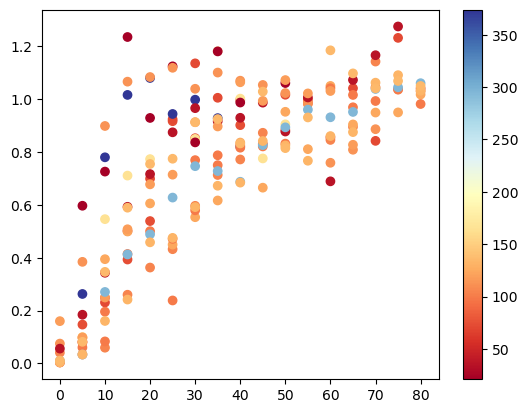

In [132]:
# scatterplot
plt.scatter(x=df_pz1['pressure'], y=df_pz1['avg_norm_current'], c=df_pz1['p50_avg_max_current'], cmap="RdYlBu")
plt.
plt.colorbar(orientation="vertical")
# plt.show()

<AxesSubplot:>

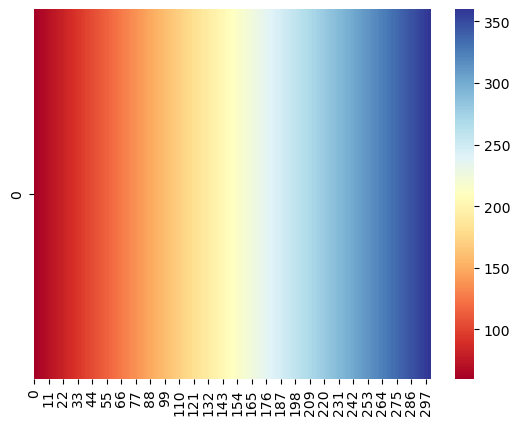

In [118]:
data=np.linspace(60, 360, 301)
data_reshaped = data.reshape(1, -1)
sns.heatmap(data_reshaped, cmap='RdYlBu')

In [114]:
data.shape

(301,)

In [ ]:
# colors

# df_loaded, '#D5CAFF', '#601ef9'
# df_blank, '#D5CAFF', 'lightpink'
# df_pz1, 'gold', 'orange'

p50_basic_fig=P50_norm_scatter_basic(df_pz1, '#D5CAFF', '#601ef9')
construct='hPz1'
# p50_basic_fig.savefig('D:/tension_expt_2023_06/weekend_2023_07_08/analyzed_data_figures/p50_basic_'+construct+'.png', transparent=True,  bbox_inches='tight', dpi=1000)


P50 value from Boltzman Fit:  9.406129350198059 mmHg
k value from Boltzman Fit:  0.15936686394775074


C:\Users\mjs164\AppData\Local\Temp\ipykernel_18716\4067549926.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_summary['p50_avgm'] = p50_list_avgm
C:\Users\mjs164\AppData\Local\Temp\ipykernel_18716\4067549926.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_summary['k_avgm_slope'] = k_avgm_slope_list


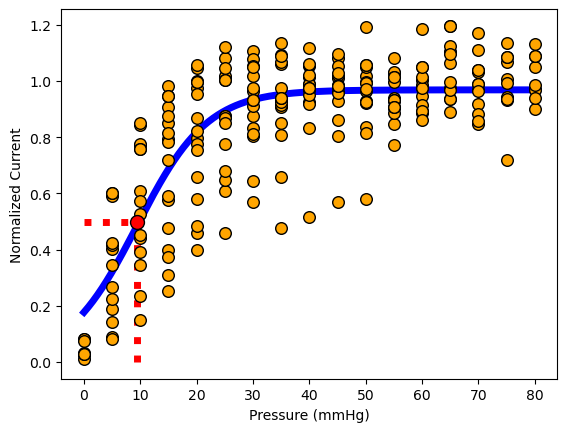

C:\Users\mjs164\AppData\Local\Temp\ipykernel_18716\4067549926.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_summary['p50_absm'] = p50_list_absm
C:\Users\mjs164\AppData\Local\Temp\ipykernel_18716\4067549926.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_summary['k_absm_slope'] = k_absm_slope_list


In [25]:
#determine P50 and k for multiple patches
pop_p50_fig=generate_p50_norm(df_loaded)

In [ ]:
#making a graph with the p50 fits
linecolor_dict= {'df_pz1': 'gold', 'df_pz2': 'violet', 'df_loaded': '#D5CAFF', 'df_blank': 'lavenderblush'}
conscruct_df_dict= {'df_pz1': df_pz1, 'df_pz2': df_pz2, 'df_loaded': df_loaded, 'df_blank': df_blank}
P50_fit_compare_fig=P50_fit_compare(linecolor_dict, conscruct_df_dict)
# P50_compare_fig.savefig('Z:/All_Staff/Grandl Lab/Michael Sindoni/mem_imaging_project/tension_expt_2023_06/analyzed_data_figures/p50_compare.png', transparent=True,  bbox_inches='tight', dpi=1000)


In [ ]:
linecolor_dict= {'df_pz1': 'gold', 'df_pz2': 'violet', 'df_loaded': '#D5CAFF', 'df_blank': 'lavenderblush'}
conscruct_df_dict= {'df_pz1': df_pz1, 'df_pz2': df_pz2, 'df_loaded': df_loaded, 'df_blank': df_blank}
p50_stdev_fig=P50_stdev_compare(linecolor_dict, conscruct_df_dict)
# p50_stdev_fig.savefig('Z:/All_Staff/Grandl Lab/Michael Sindoni/mem_imaging_project/tension_expt_2023_06/analyzed_data_figures/p50_stdev.png', transparent=True,  bbox_inches='tight', dpi=1000)


In [ ]:
#make P50, k, max current box plot
color_list= ['gold','violet','#D5CAFF', 'lavenderblush']
conscruct_df_dict= {'df_pz1': df_pz1, 'df_pz2': df_pz2, 'df_loaded': df_loaded, 'df_blank': df_blank}
P50_k_max_boxplot_fig=P50_k_max_boxplot(color_list, conscruct_df_dict)
# fig.savefig('D:/tension_expt_2023_06/weekend_2023_07_08/analyzed_data_figures/P50_k_max_boxplot_fig.png', transparent=True,  bbox_inches='tight', dpi=1000)


In [18]:
def generate_T50_norm(df_piezos):
    '''
    This function fits a Boltzmann function to the tension vs. average normalized current data and generates a plot.

    Inputs:
      df_piezos: DataFrame containing tension and average normalized current data.

    Outputs:
      fig: Figure object containing the plot.
    '''

    # Fit a Boltzmann function to the data
    popt, pcov = curve_fit(fit_boltz, df_piezos['tension'], df_piezos['avg_norm_current'],
                          bounds=([-np.inf, -np.inf, -np.inf], [np.inf, np.inf, np.inf]))

    # Generate x and y data for the fitted curve
    x_gen_data = np.linspace(0, df_piezos['tension'].max(), 500)
    y_gen_data = fit_boltz(x_gen_data, *popt)
    
    # Create a figure and axis object
    fig, ax = plt.subplots()

    # Plot the scatter of tension vs. average normalized current
    ax.scatter(df_piezos['tension'], df_piezos['avg_norm_current'], color='orange', edgecolor='black', s=60, zorder=2)

    # Plot the fitted curve
    ax.plot(x_gen_data, y_gen_data, color='blue', linewidth=5, zorder=1)

    # Set the labels and tick parameters
    ax.set_xlabel('Tension (mN/m)', fontsize=12)
    ax.set_ylabel('Normalized Max Current', fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    # Print the fitted parameters
    print('T50:', round(popt[1], 3))
    print('k:', round(popt[2], 3))

    return fig

T50: 2.125
k: 1.868


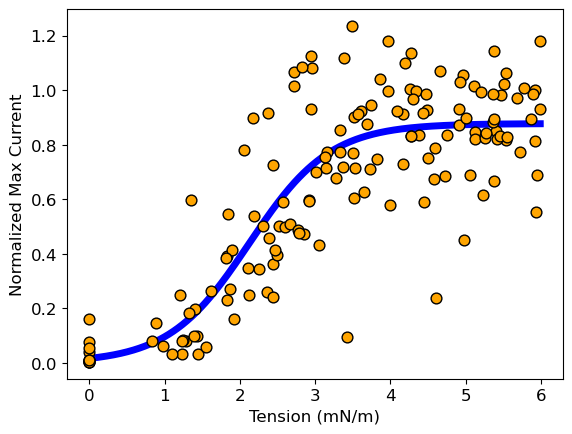

In [23]:
df_pz1_tension_cut=df_pz1.loc[df_pz1['tension']<=6]
t50_basic=generate_T50_norm(df_pz1_tension_cut)


T50: 1.272
k: 0.979


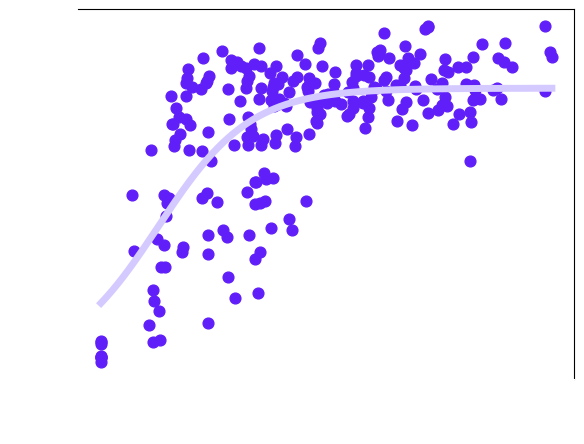

In [22]:
# colors

# df_loaded, '#D5CAFF', '#601ef9'
# df_blank, '#D5CAFF', 'lightpink'
# df_pz1, 'gold', 'orange'
# df_pz1, 'violet', 'fuchsia'

#make individual T50 scatterplots
t50_basic_fig=T50_norm_scatter_basic(df_loaded, '#D5CAFF', '#601ef9')
construct='loaded'
# t50_basic_fig.savefig('Z:/All_Staff/Grandl Lab/Michael Sindoni/mem_imaging_project/tension_expt_2023_06/analyzed_data_figures/t50_basic_'+construct+'.png', transparent=True,  bbox_inches='tight', dpi=1000)
# t50_basic_fig.savefig('D:/tension_expt_2023_06/weekend_2023_07_08/analyzed_data_figures/t50_basic_'+construct+'.png', transparent=True,  bbox_inches='tight', dpi=1000)

In [ ]:
#making a graph with the t50 fits
linecolor_dict= {'df_pz1': 'gold', 'df_pz2': 'violet', 'df_loaded': '#D5CAFF', 'df_blank': 'lavenderblush'}
conscruct_df_dict= {'df_pz1': df_pz1, 'df_pz2': df_pz2, 'df_loaded': df_loaded, 'df_blank': df_blank}
T50_fit_compare_fig=T50_fit_compare(linecolor_dict, conscruct_df_dict)
# T50_fit_compare_fig.savefig('D:/tension_expt_2023_06/weekend_2023_07_08/analyzed_data_figures/t50_fit_compare.png', transparent=True,  bbox_inches='tight', dpi=1000)

In [ ]:
linecolor_dict= {'df_pz1': 'gold', 'df_pz2': 'violet', 'df_loaded': '#D5CAFF', 'df_blank': 'lavenderblush'}
conscruct_df_dict= {'df_pz1': df_pz1, 'df_pz2': df_pz2, 'df_loaded': df_loaded, 'df_blank': df_blank}
t50_stdev_fig=T50_stdev_compare(linecolor_dict, conscruct_df_dict)
# t50_stdev_fig.savefig('D:/tension_expt_2023_06/weekend_2023_07_08/analyzed_data_figures/t50_stdev_compare.png', transparent=True,  bbox_inches='tight', dpi=1000)

In [ ]:
conscruct_df_dict= {'df_pz1': df_pz1, 'df_pz2': df_pz2, 'df_loaded': df_loaded, 'df_blank': df_blank}
color_list= ['gold','violet','#D5CAFF', 'lavenderblush']
T50_k_boxplot_fig=T50_k_boxplot(color_list, conscruct_df_dict)
# T50_k_boxplot_fig.savefig('D:/tension_expt_2023_06/weekend_2023_07_08/analyzed_data_figures/t50_k_boxplot_fig.png', transparent=True,  bbox_inches='tight', dpi=1000)


In [ ]:
unique_list=[]
grouped=df_piezos.groupby(['date', 'number'])
for name,group in grouped:
    unique_list.append(group['category'].iloc[0])
total_len=len(unique_list)
num_hpz1=int(unique_list.count('hPz1'))
num_hpz2=int(unique_list.count('hPz2'))
num_blank=int(unique_list.count('blank'))
num_loaded=int(unique_list.count('loaded'))
print(total_len, num_hpz1, num_hpz2, num_blank, num_loaded)

<re.Match object; span=(0, 10), match='2023_06_12'>
2023_06_12
10
165.1594552
<re.Match object; span=(0, 10), match='2023_06_12'>
2023_06_12
11
104.7572478
<re.Match object; span=(0, 10), match='2023_06_12'>
2023_06_12
20
33.4251188
<re.Match object; span=(0, 10), match='2023_06_12'>
2023_06_12
23
67.40693543
<re.Match object; span=(0, 10), match='2023_06_12'>
2023_06_12
25
67.40693543
<re.Match object; span=(0, 10), match='2023_06_12'>
2023_06_12
27
not present
<re.Match object; span=(0, 10), match='2023_06_12'>
2023_06_12
29
not present


KeyboardInterrupt: 

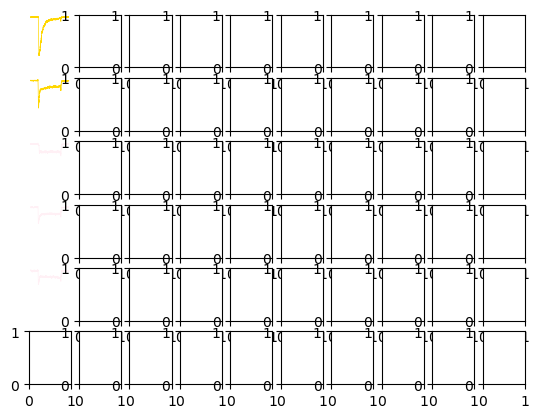

In [40]:
#generating traces figures
# date=
# number
# file=''

linecolor_dict= {'hPz1': 'gold', 'hPz2': 'violet', 'loaded': '#D5CAFF', 'blank': 'lavenderblush'}

fig, ax=plt.subplots(6, 10)
column_count=0
row_count=0

directory = 'Z:/All_Staff/Grandl Lab/Michael Sindoni/mem_imaging_project/tension_expt_2023_06/ascii_files/done'
for filename in os.listdir(directory):
    #loading individual ascii files
    df_ephys = load_dataframe(directory+'/'+filename)
    
    #using regular expression to pull out date and number
    date_pattern = r"\d{4}_\d{2}_\d{2}"
    time_pattern = r"\d{1,2}(?=\.)"
    date_match = re.search(date_pattern, filename)
    time_match = re.search(time_pattern, filename)
    print(date_match)
    if date_match and time_match:
        date_part = date_match.group()
        time_part = time_match.group()
        print(date_part)
        print(time_part)
    else:
        print("No match found.")

    #determining last sweep number from summary data df
    max_sweep=df_piezos['sweep'].loc[(df_piezos['date']==date_part) & (df_piezos['number']==float(time_part))].max()

    if math.isnan(max_sweep):
        print('not present')
        continue
    else:
        #only analyzing traces that have a plateau current >20pA
        if df_piezos['p50_avg_max_current'].loc[(df_piezos['date']==date_part) & (df_piezos['number']==float(time_part))].iloc[0]>20:
            print(df_piezos['p50_avg_max_current'].loc[(df_piezos['date']==date_part) & (df_piezos['number']==float(time_part))].iloc[0])
            
            #determining last sweep number from summary data df
            max_sweep=df_piezos['sweep'].loc[(df_piezos['date']==date_part) & (df_piezos['number']==float(time_part))].max()

            #pulling out raw ephys data for the last sweep with
            last_sweep_ephys=df_ephys.loc[df_ephys['sweep']==max_sweep]
            #determining the category of channel
            category=str(df_piezos['category'].loc[(df_piezos['date']==date_part) & (df_piezos['number']==float(time_part))].iloc[0])

            #isolating range to see pressure step current
            cut_last_sweep=last_sweep_ephys.loc[(last_sweep_ephys['ti']>=4900) & (last_sweep_ephys['ti']<=5400)]
            ax[row_count,column_count].plot(cut_last_sweep['ti'], cut_last_sweep['i'], color=linecolor_dict[str(category)], linewidth=0.5)
        #     ax.plot([5325, 5325],[-100, -150], color='black', linewidth=0.5)
        #     ax.plot([5325, 5385],[-150, -150], color='black', linewidth=0.5)
            ax[row_count,column_count].set_ylim(-200, 10)
            ax[row_count,column_count].axis('off')
            if row_count%5==0 and row_count!=0:
                column_count+=1
                row_count=0
            else:
                row_count+=1
        else:
            print(date_part, time_part, 'not above 20pA')

In [ ]:
ax[2,9].axis('off')
ax[3,9].axis('off')
ax[4,9].axis('off')
ax[5,9].axis('off')
fig.savefig('Z:/All_Staff/Grandl Lab/Michael Sindoni/mem_imaging_project/tension_expt_2023_06/analyzed_data_figures/all_traces.png', transparent=True,  bbox_inches='tight', dpi=1000)

(-20.0, 100.0)

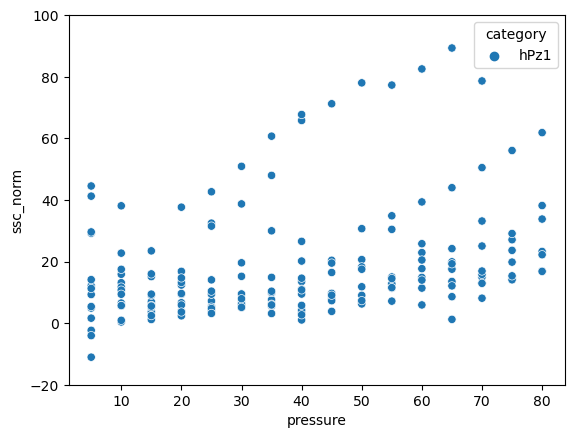

In [19]:
df1_above_zero=df_pz1.loc[df_pz1['pressure']>0]
sns.scatterplot(data=df1_above_zero, x='pressure', y='ssc_norm', hue='category')
plt.ylim(-20, 100)

(-20.0, 100.0)

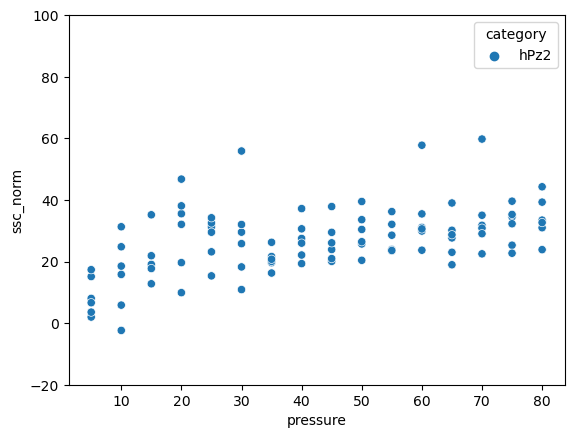

In [20]:
df2_above_zero=df_pz2.loc[df_pz2['pressure']>0]
sns.scatterplot(data=df2_above_zero, x='pressure', y='ssc_norm', hue='category')
plt.ylim(-20, 100)

(-20.0, 100.0)

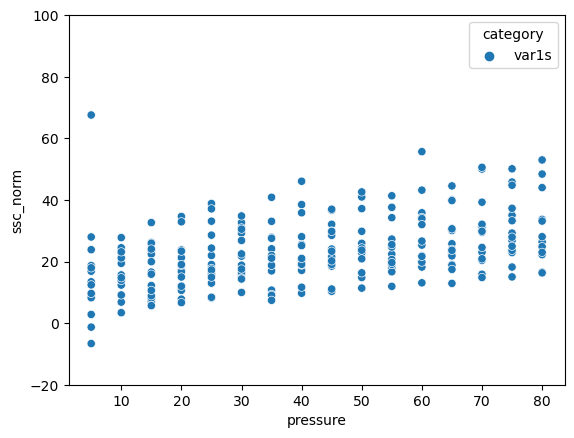

In [21]:
df_var1s_above_zero=df_var1s.loc[df_var1s['pressure']>0]
sns.scatterplot(data=df_var1s_above_zero, x='pressure', y='ssc_norm', hue='category')
plt.ylim(-20, 100)

(-20.0, 100.0)

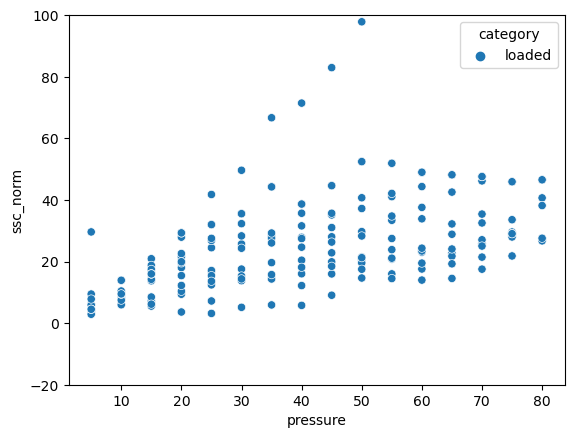

In [22]:
dfloaded_above_zero=df_loaded.loc[df_piezos['pressure']>0]
sns.scatterplot(data=dfloaded_above_zero, x='pressure', y='ssc_norm', hue='category')
plt.ylim(-20, 100)

<AxesSubplot:xlabel='pressure', ylabel='ssc_norm'>

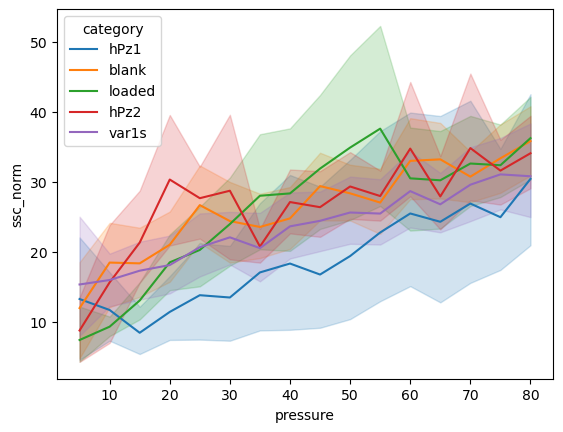

In [25]:
df_piezos_cut=df_piezos.loc[(df_piezos['tension']<12) & (df_piezos['p50_avg_max_current']>30) & (df_piezos['percent_std_error_rad']<=10)& (df_piezos['pressure']>0)]


sns.lineplot(data=df_piezos_cut, x='pressure', y='ssc_norm', hue='category')




<re.Match object; span=(0, 10), match='2023_06_12'>
2023_06_12
10
165.1594552


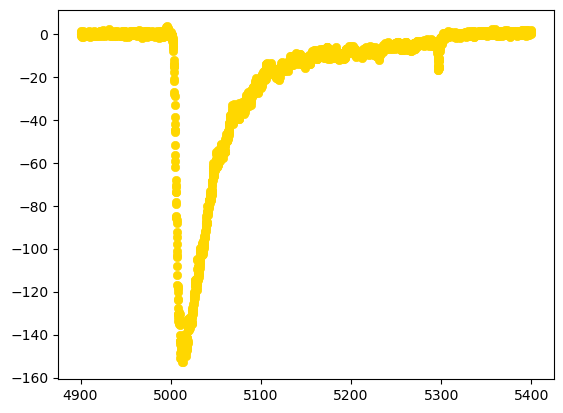

<re.Match object; span=(0, 10), match='2023_06_12'>
2023_06_12
11
104.7572478


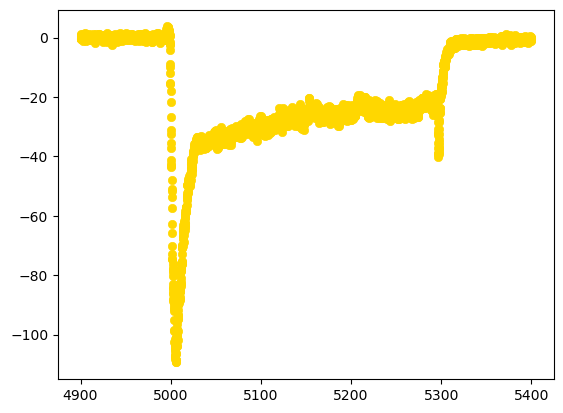

<re.Match object; span=(0, 10), match='2023_06_12'>
2023_06_12
20
33.4251188


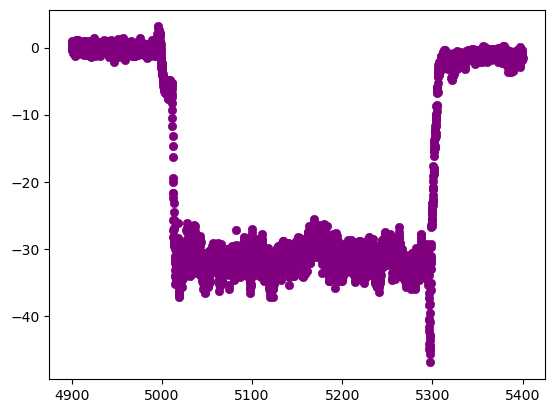

<re.Match object; span=(0, 10), match='2023_06_12'>
2023_06_12
23
67.40693543


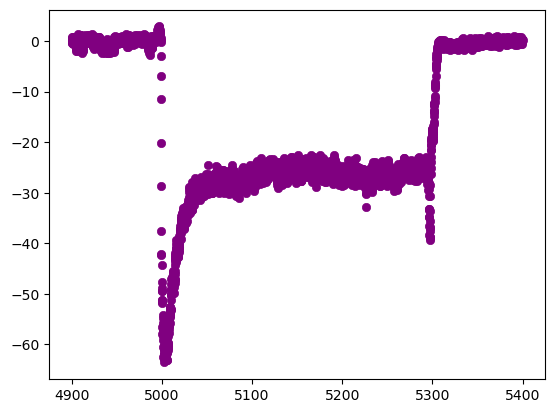

<re.Match object; span=(0, 10), match='2023_06_12'>
2023_06_12
25
67.40693543


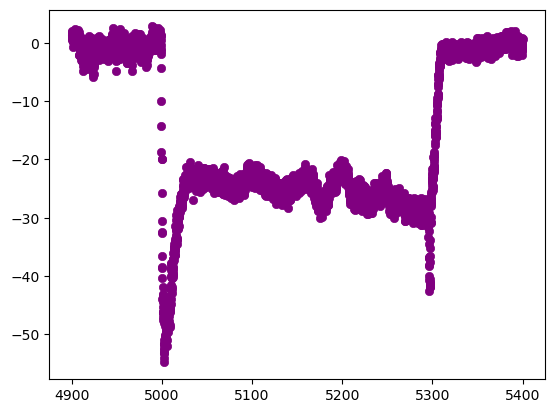

<re.Match object; span=(0, 10), match='2023_06_12'>
2023_06_12
27
not present
<re.Match object; span=(0, 10), match='2023_06_12'>
2023_06_12
29
not present
<re.Match object; span=(0, 10), match='2023_06_12'>
2023_06_12
34
36.82084042


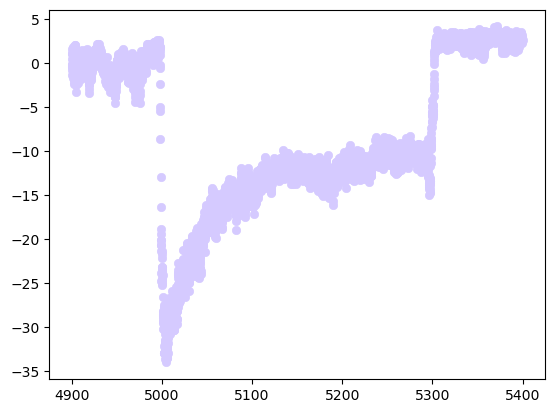

<re.Match object; span=(0, 10), match='2023_06_12'>
2023_06_12
36
244.3712812


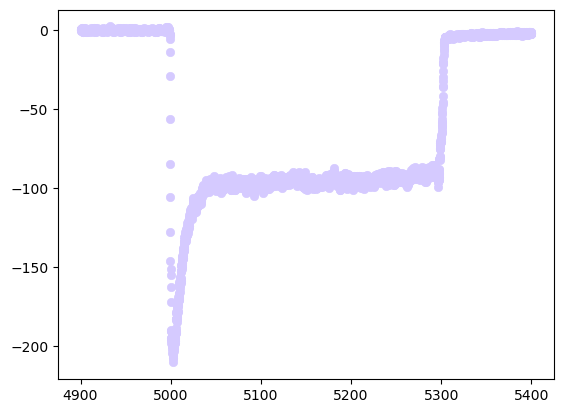

<re.Match object; span=(0, 10), match='2023_06_12'>
2023_06_12
6
74.01673391


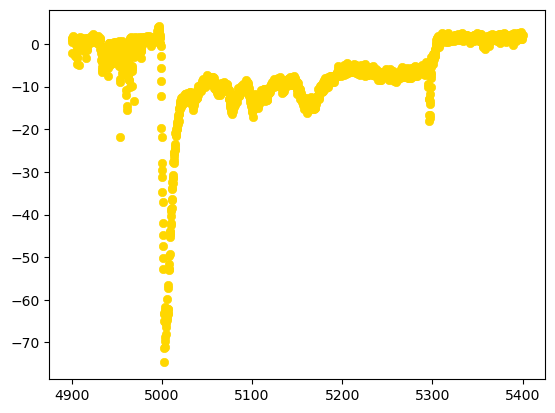

<re.Match object; span=(0, 10), match='2023_06_12'>
2023_06_12
7
71.28197642


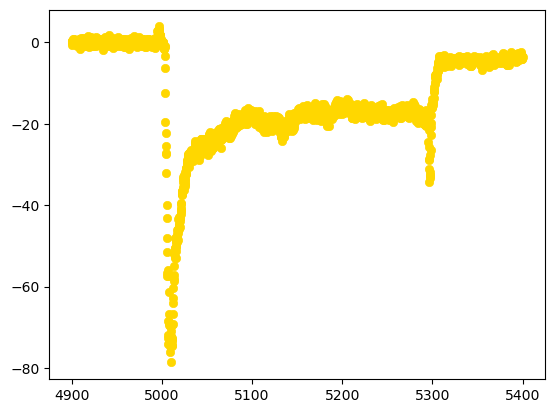

<re.Match object; span=(0, 10), match='2023_06_13'>
2023_06_13
15
not present
<re.Match object; span=(0, 10), match='2023_06_13'>
2023_06_13
16
51.81957714


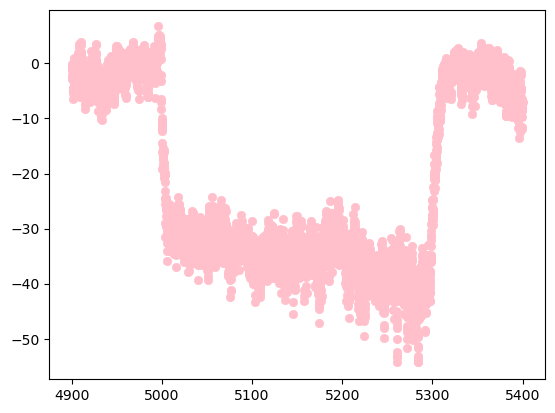

<re.Match object; span=(0, 10), match='2023_06_13'>
2023_06_13
18
31.407854


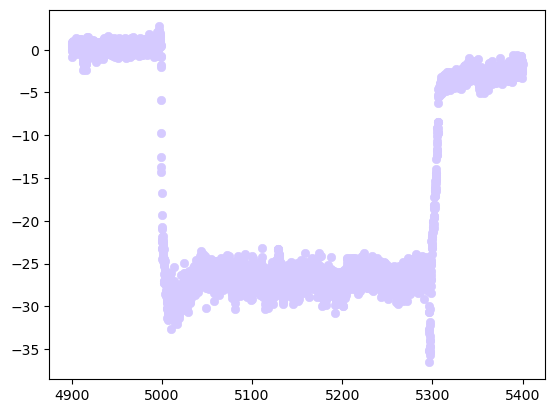

<re.Match object; span=(0, 10), match='2023_06_13'>
2023_06_13
20
47.00987169


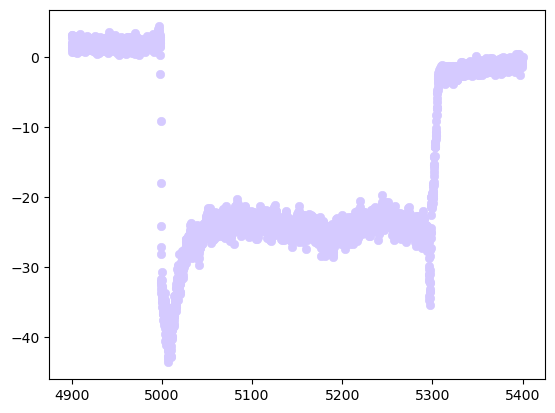

<re.Match object; span=(0, 10), match='2023_06_13'>
2023_06_13
24
75.73843692


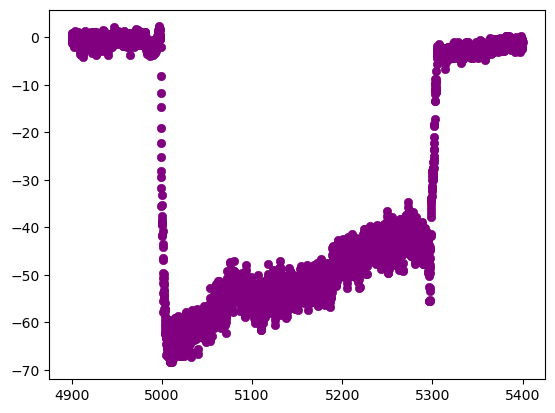

<re.Match object; span=(0, 10), match='2023_06_13'>
2023_06_13
26
64.27688702


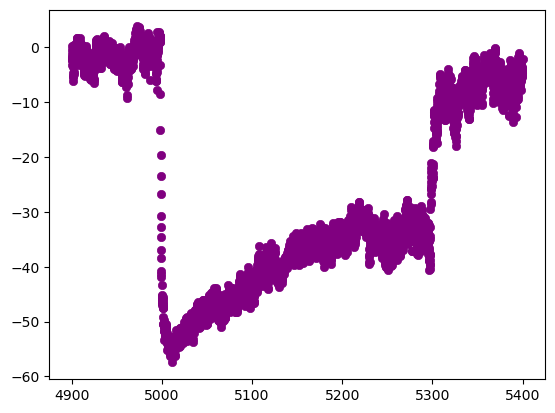

<re.Match object; span=(0, 10), match='2023_06_13'>
2023_06_13
4
123.6547743


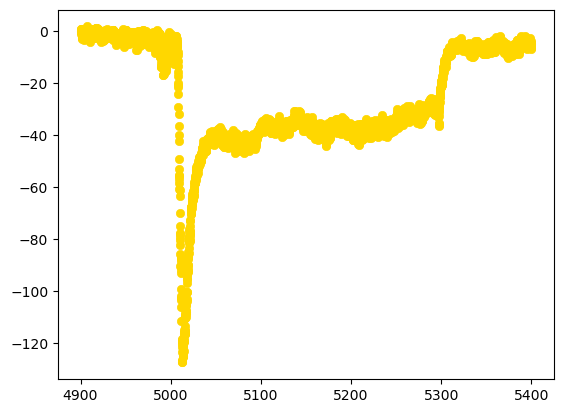

<re.Match object; span=(0, 10), match='2023_06_13'>
2023_06_13
7
373.9209911


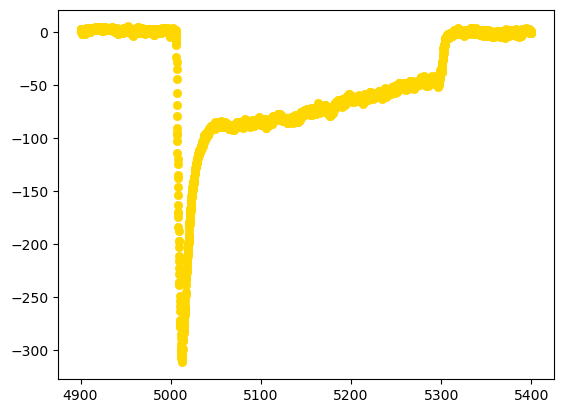

<re.Match object; span=(0, 10), match='2023_06_14'>
2023_06_14
1
99.08054683


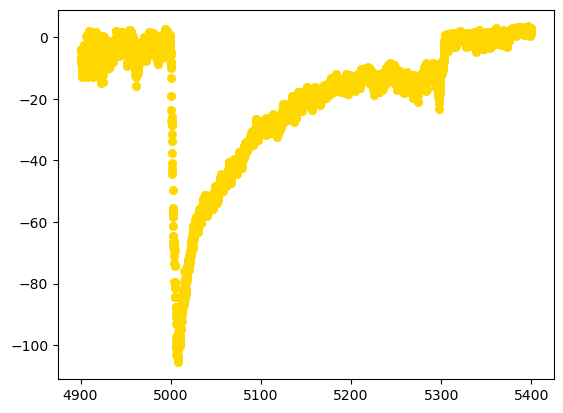

<re.Match object; span=(0, 10), match='2023_06_14'>
2023_06_14
15
50.03939016


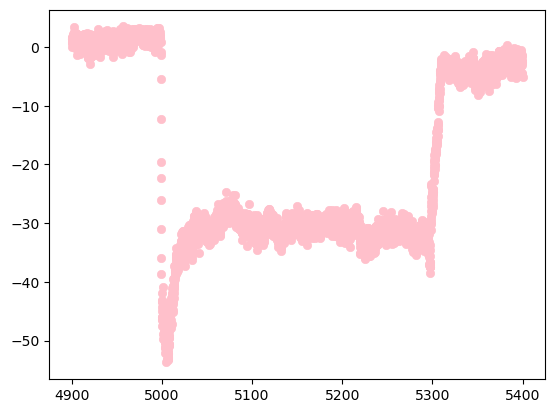

<re.Match object; span=(0, 10), match='2023_06_14'>
2023_06_14
16
61.89768094


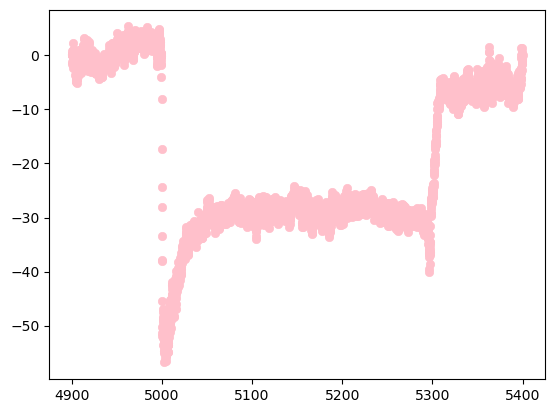

<re.Match object; span=(0, 10), match='2023_06_14'>
2023_06_14
2
20.99439646


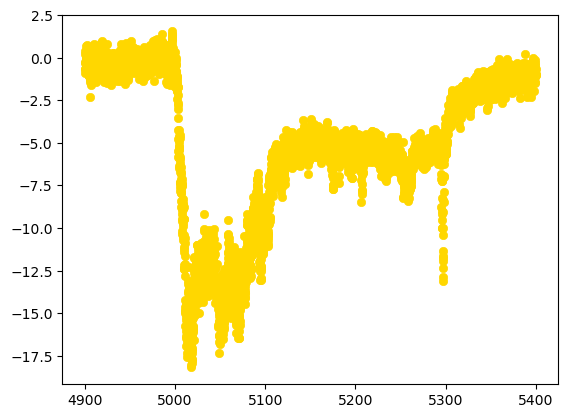

<re.Match object; span=(0, 10), match='2023_06_14'>
2023_06_14
20
47.91127348


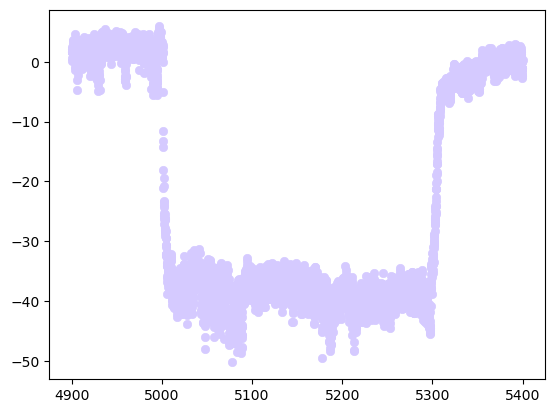

<re.Match object; span=(0, 10), match='2023_06_14'>
2023_06_14
21
80.67479976


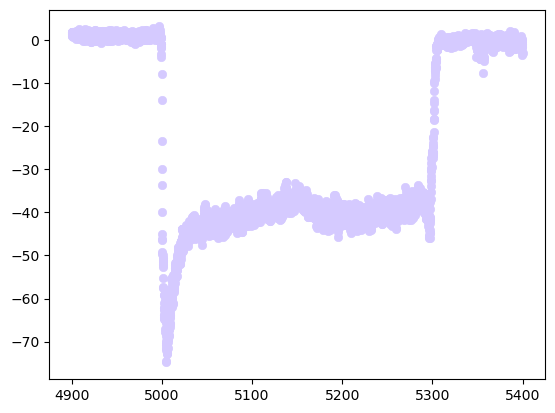

<re.Match object; span=(0, 10), match='2023_06_14'>
2023_06_14
22
54.73168337


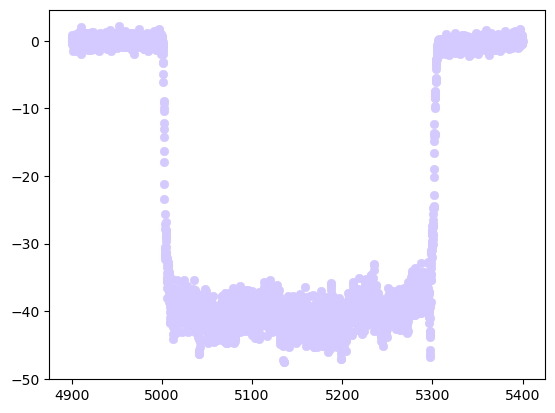

<re.Match object; span=(0, 10), match='2023_06_14'>
2023_06_14
23
2023_06_14 23 not above 20pA
<re.Match object; span=(0, 10), match='2023_06_14'>
2023_06_14
4
99.26680372


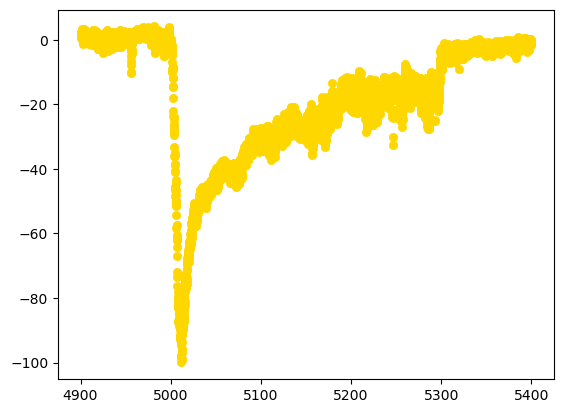

<re.Match object; span=(0, 10), match='2023_06_14'>
2023_06_14
6
27.12262811


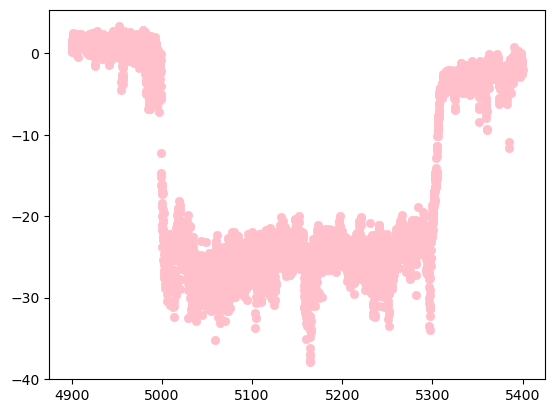

<re.Match object; span=(0, 10), match='2023_06_15'>
2023_06_15
10
not present
<re.Match object; span=(0, 10), match='2023_06_15'>
2023_06_15
14
26.11345157


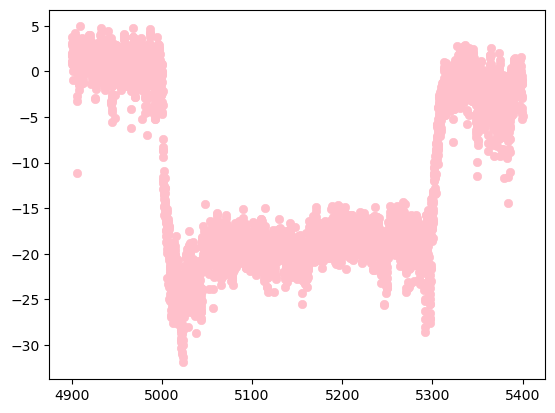

<re.Match object; span=(0, 10), match='2023_06_15'>
2023_06_15
16
41.77994988


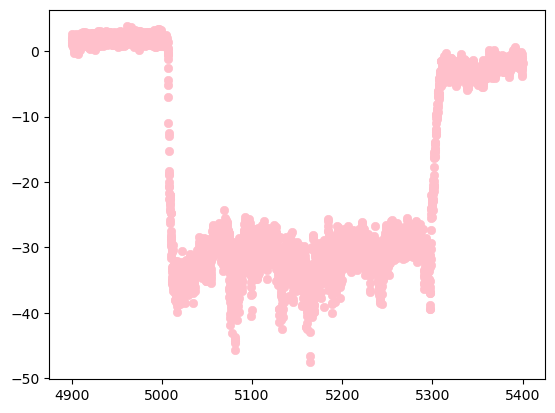

<re.Match object; span=(0, 10), match='2023_06_15'>
2023_06_15
17
26.18899248


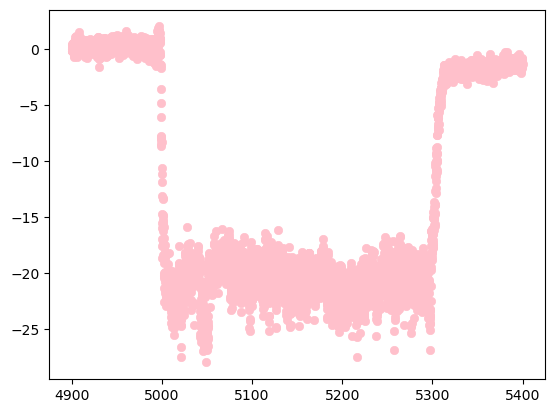

<re.Match object; span=(0, 10), match='2023_06_15'>
2023_06_15
22
20.08078614


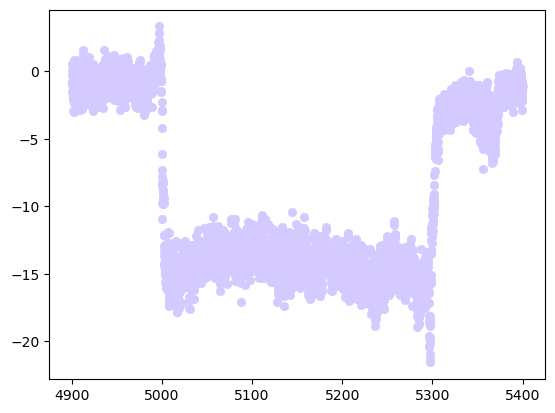

<re.Match object; span=(0, 10), match='2023_06_15'>
2023_06_15
25
33.02702967


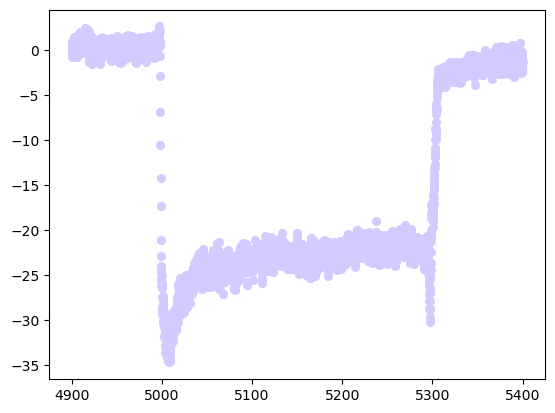

<re.Match object; span=(0, 10), match='2023_06_15'>
2023_06_15
5
not present
<re.Match object; span=(0, 10), match='2023_06_15'>
2023_06_15
8
55.87654869


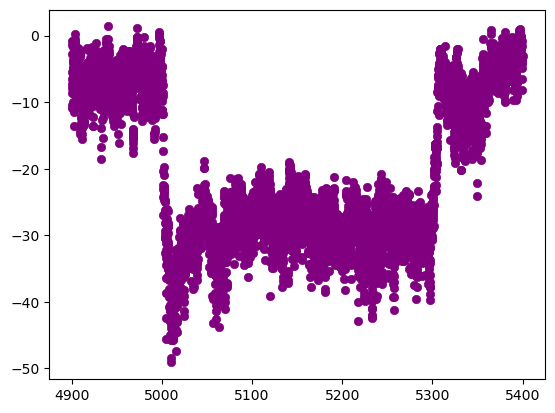

<re.Match object; span=(0, 10), match='2023_06_15'>
2023_06_15
9
2023_06_15 9 not above 20pA
<re.Match object; span=(0, 10), match='2023_06_16'>
2023_06_16
3
20.43552822


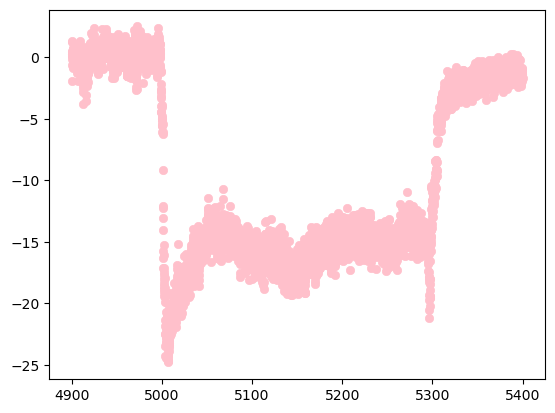

<re.Match object; span=(0, 10), match='2023_06_23'>
2023_06_23
14
30.7555185


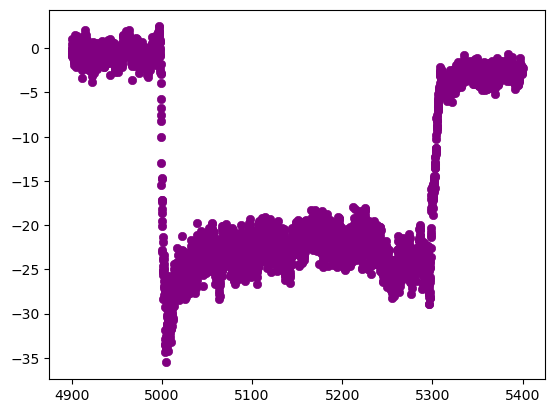

<re.Match object; span=(0, 10), match='2023_06_23'>
2023_06_23
24
20.88620298


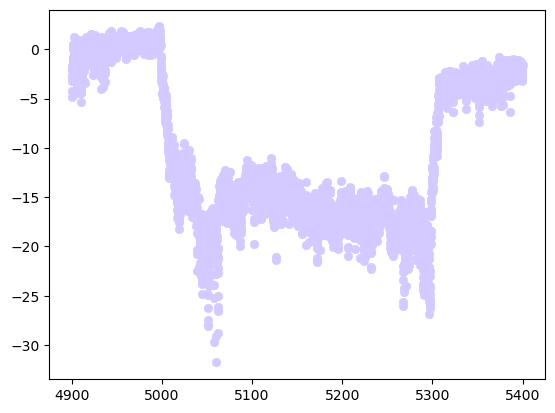

<re.Match object; span=(0, 10), match='2023_06_23'>
2023_06_23
26
28.90256907


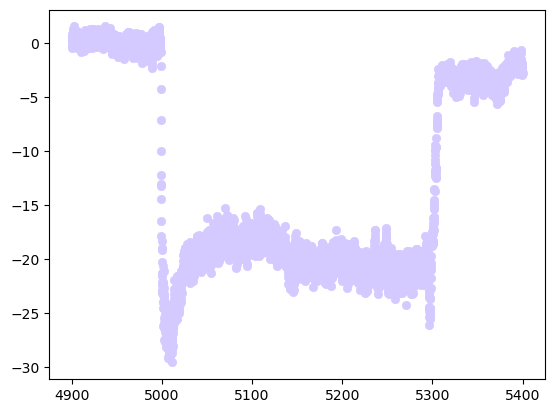

<re.Match object; span=(0, 10), match='2023_06_23'>
2023_06_23
4
104.7597874


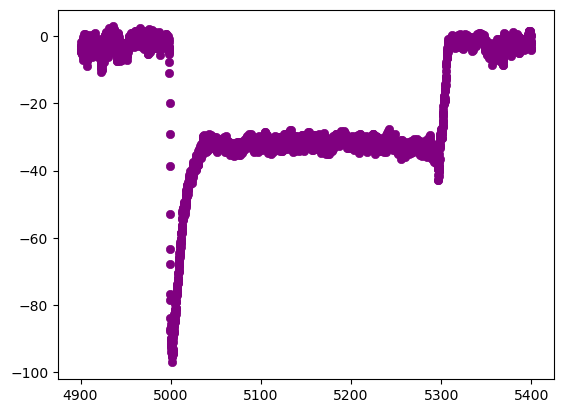

<re.Match object; span=(0, 10), match='2023_06_27'>
2023_06_27
18
55.44156118


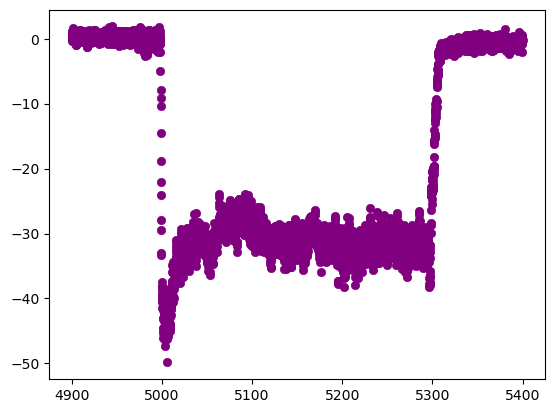

<re.Match object; span=(0, 10), match='2023_06_27'>
2023_06_27
2
112.8529678


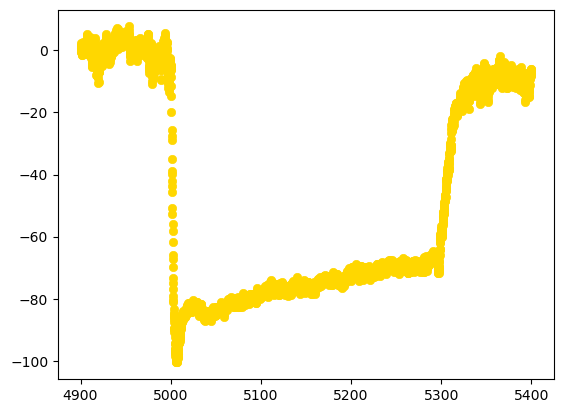

<re.Match object; span=(0, 10), match='2023_06_27'>
2023_06_27
20
141.7653444


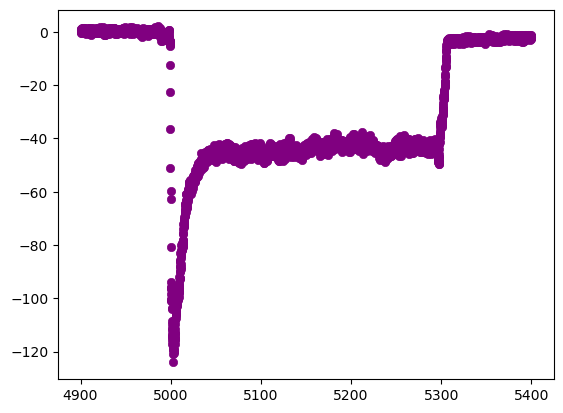

<re.Match object; span=(0, 10), match='2023_06_27'>
2023_06_27
29
32.87800531


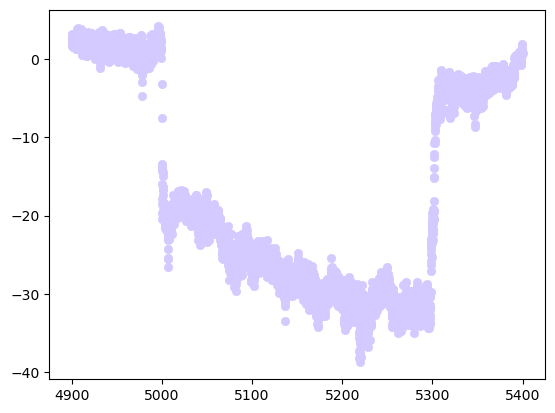

<re.Match object; span=(0, 10), match='2023_06_27'>
2023_06_27
31
111.2257744


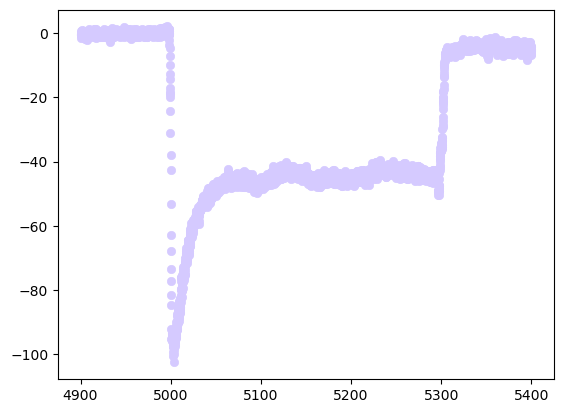

<re.Match object; span=(0, 10), match='2023_06_27'>
2023_06_27
9
68.39246771


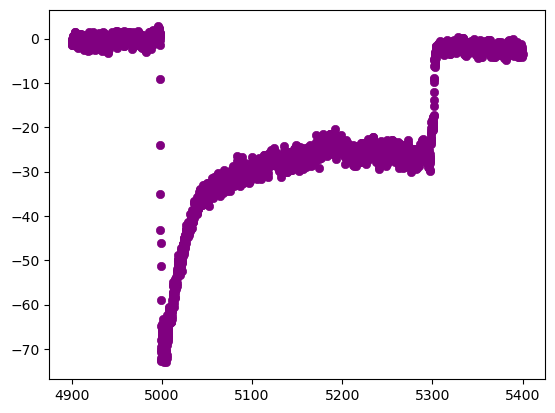

<re.Match object; span=(0, 10), match='2023_06_29'>
2023_06_29
1
35.65012256


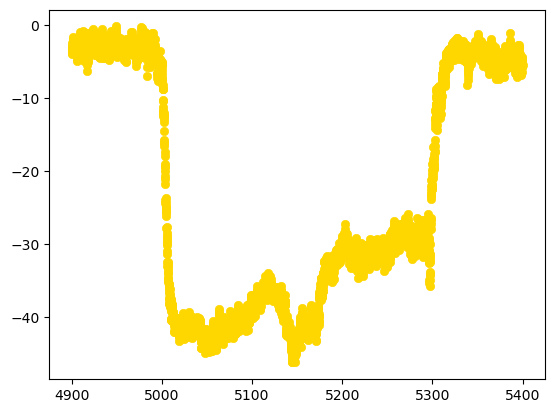

<re.Match object; span=(0, 10), match='2023_06_29'>
2023_06_29
10
294.6251187


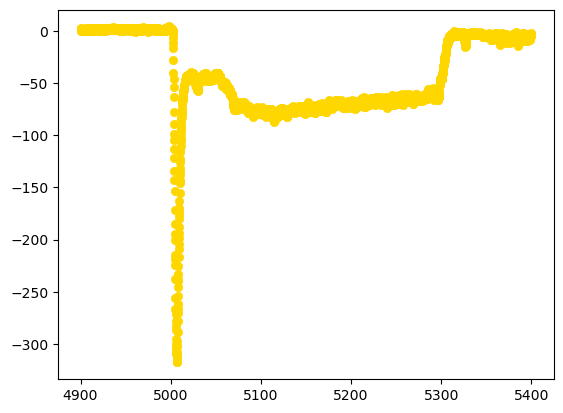

<re.Match object; span=(0, 10), match='2023_06_29'>
2023_06_29
12
132.1391156


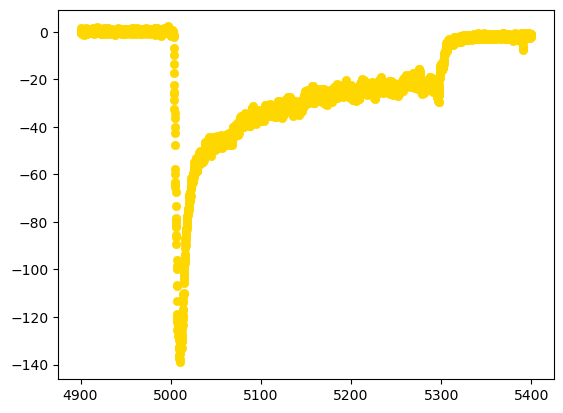

<re.Match object; span=(0, 10), match='2023_06_29'>
2023_06_29
13
135.0447474


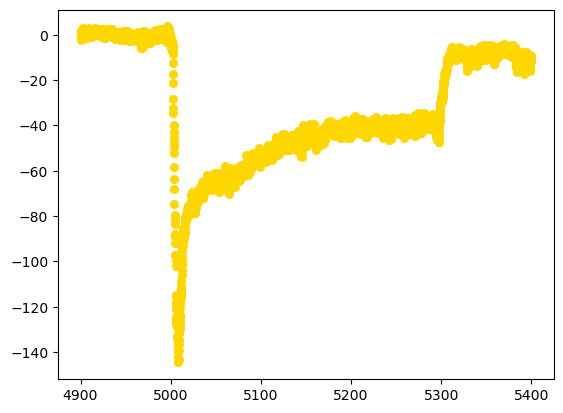

<re.Match object; span=(0, 10), match='2023_06_29'>
2023_06_29
18
135.0447474


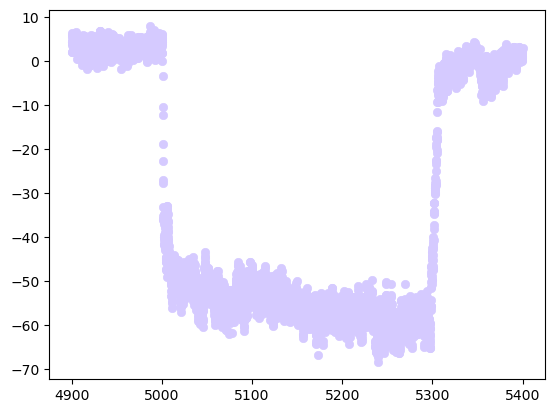

<re.Match object; span=(0, 10), match='2023_06_29'>
2023_06_29
20
60.43312453


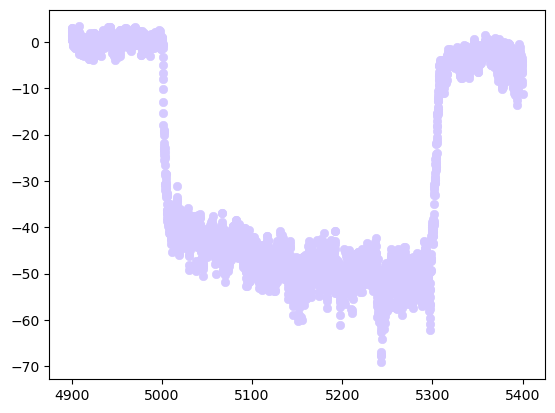

<re.Match object; span=(0, 10), match='2023_06_29'>
2023_06_29
22
60.43312453


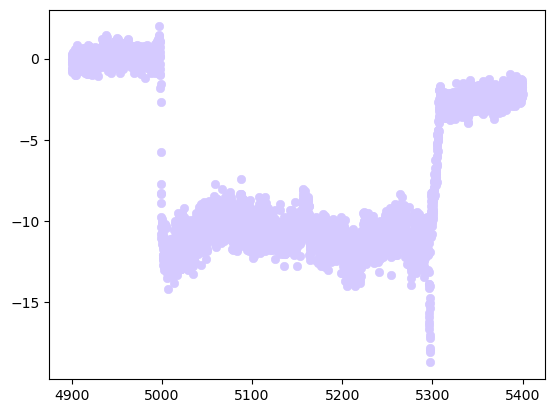

<re.Match object; span=(0, 10), match='2023_06_29'>
2023_06_29
25
35.49984459


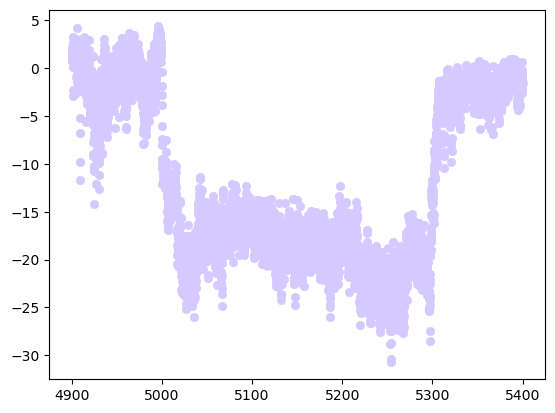

<re.Match object; span=(0, 10), match='2023_06_29'>
2023_06_29
29
46.31095033


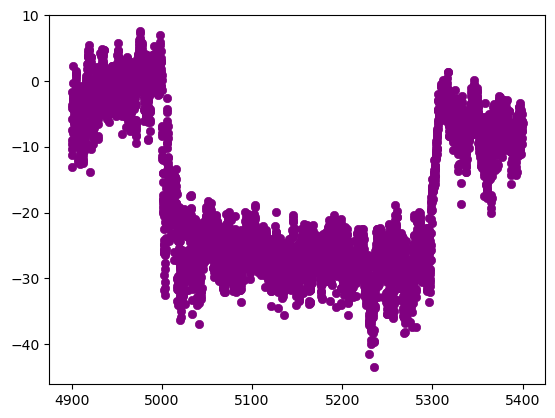

<re.Match object; span=(0, 10), match='2023_06_29'>
2023_06_29
32
45.91809072


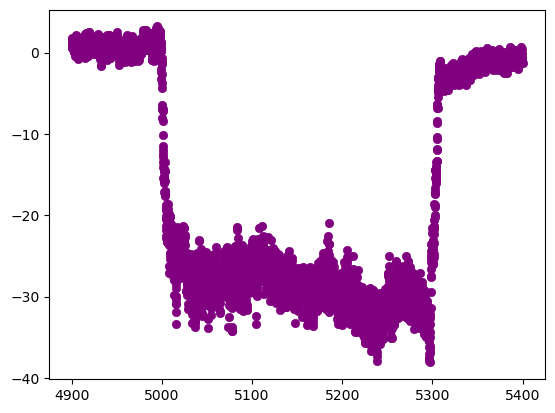

<re.Match object; span=(0, 10), match='2023_06_29'>
2023_06_29
33
45.91809072


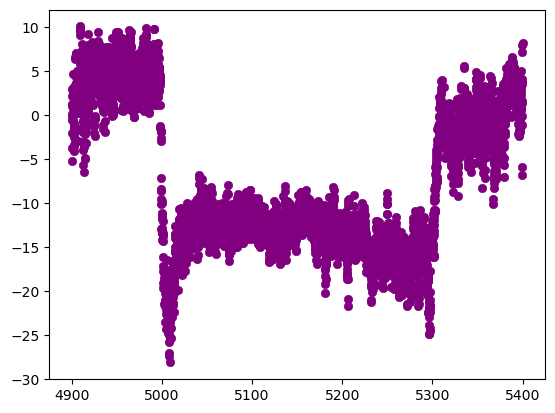

<re.Match object; span=(0, 10), match='2023_06_29'>
2023_06_29
36
202.438152


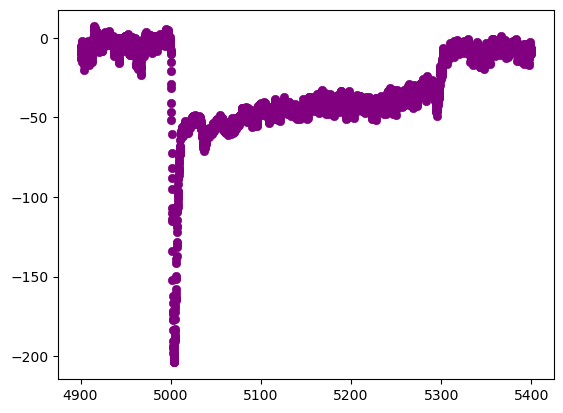

<re.Match object; span=(0, 10), match='2023_06_29'>
2023_06_29
37
198.6015693


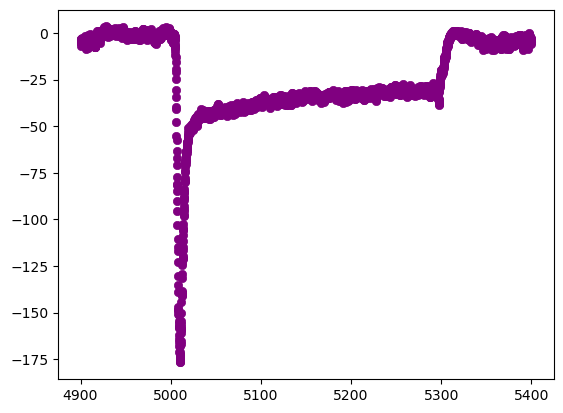

<re.Match object; span=(0, 10), match='2023_06_29'>
2023_06_29
8
118.7310436


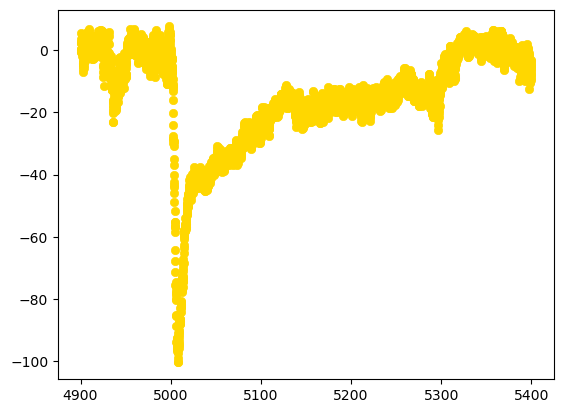

<re.Match object; span=(0, 10), match='2023_07_19'>
2023_07_19
15
34.65909911


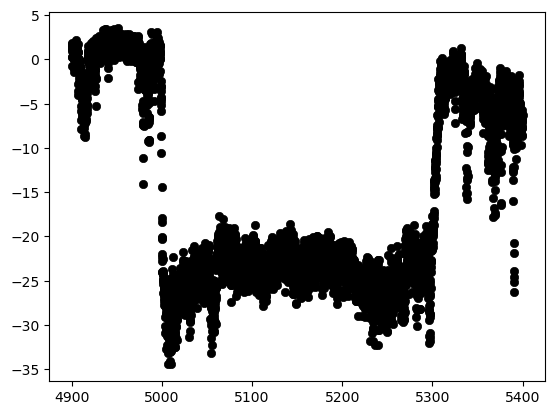

<re.Match object; span=(0, 10), match='2023_07_19'>
2023_07_19
16
52.84703202


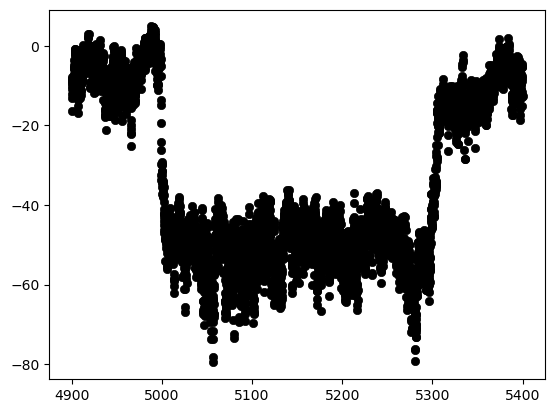

<re.Match object; span=(0, 10), match='2023_07_19'>
2023_07_19
27
62.62586227


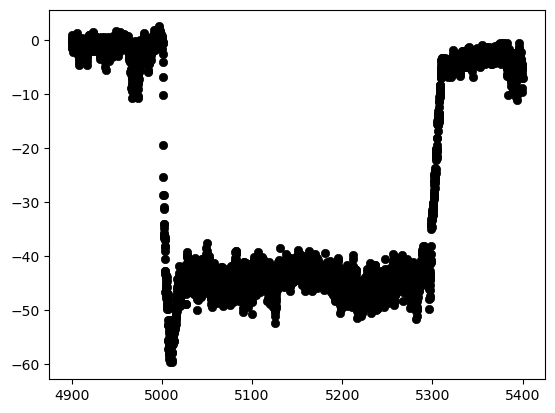

<re.Match object; span=(0, 10), match='2023_07_19'>
2023_07_19
28
36.89600375


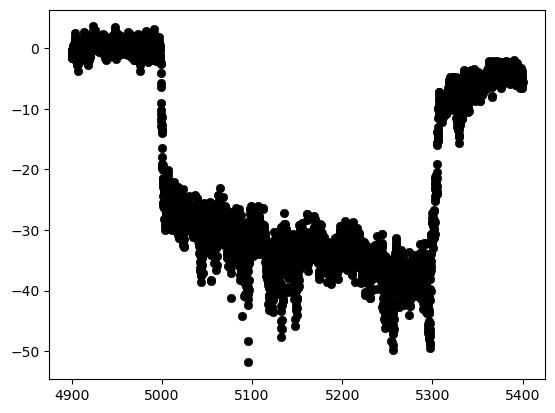

<re.Match object; span=(0, 10), match='2023_07_19'>
2023_07_19
5
50.45729197


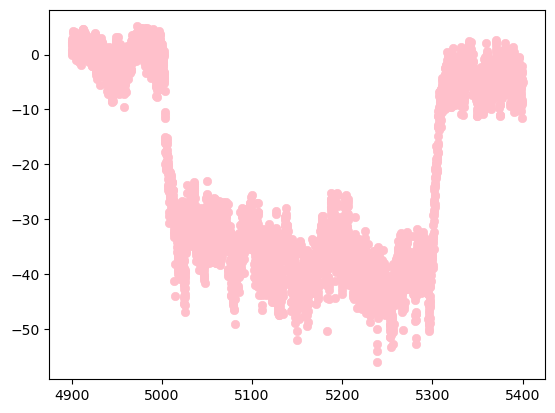

<re.Match object; span=(0, 10), match='2023_07_19'>
2023_07_19
6
31.13192429


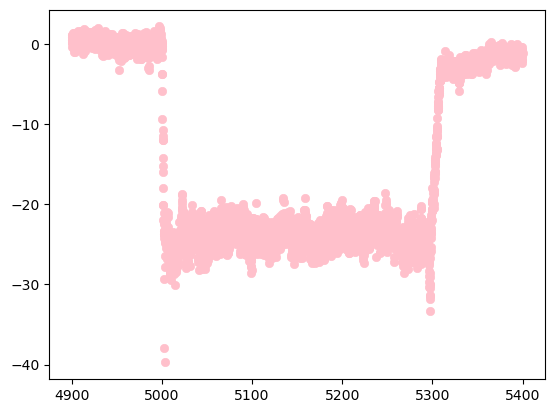

<re.Match object; span=(0, 10), match='2023_07_20'>
2023_07_20
10
112.8634093


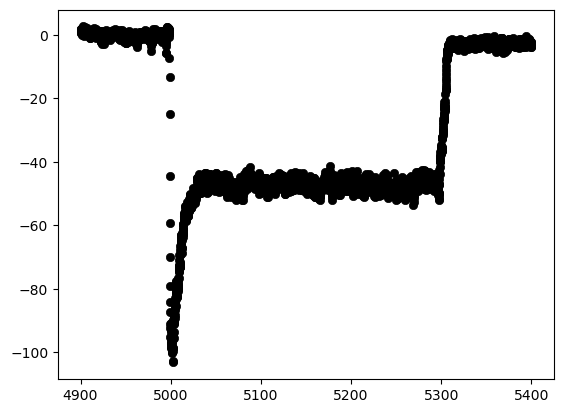

<re.Match object; span=(0, 10), match='2023_07_20'>
2023_07_20
15
38.62394939


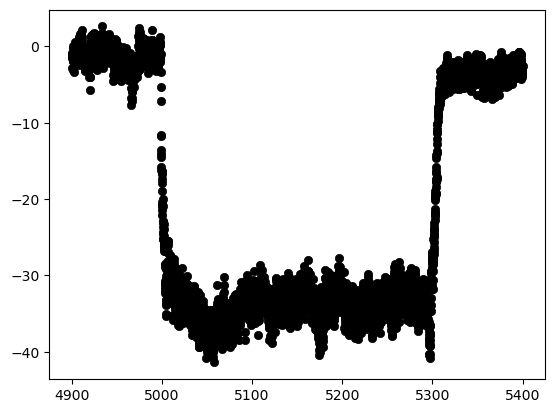

<re.Match object; span=(0, 10), match='2023_07_20'>
2023_07_20
22
not present
<re.Match object; span=(0, 10), match='2023_07_20'>
2023_07_20
23
55.85579545


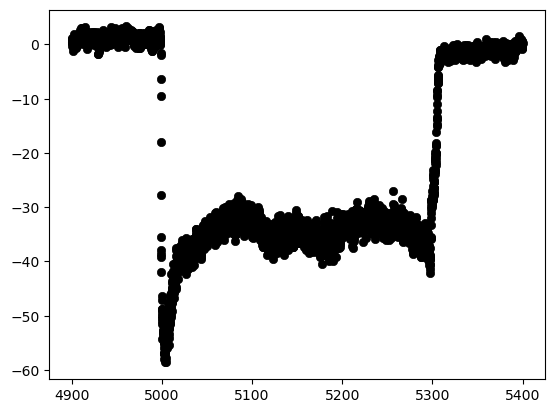

<re.Match object; span=(0, 10), match='2023_07_20'>
2023_07_20
26
39.68196587


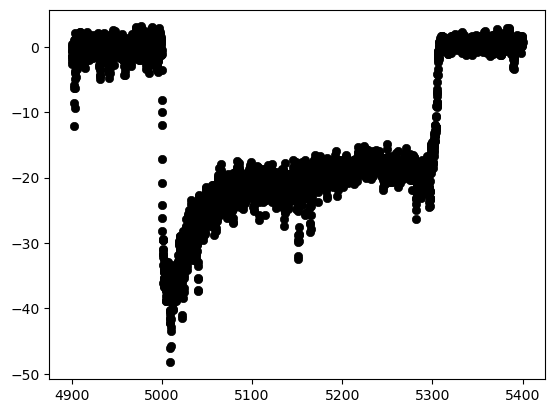

<re.Match object; span=(0, 10), match='2023_07_20'>
2023_07_20
27
43.96299298


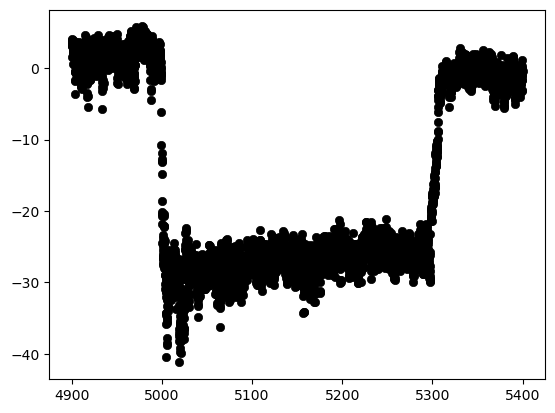

<re.Match object; span=(0, 10), match='2023_07_20'>
2023_07_20
28
31.35592259


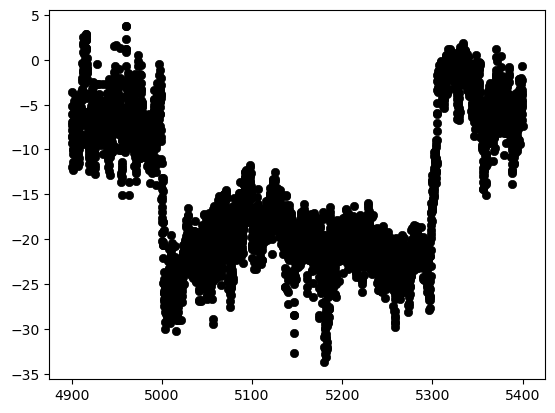

<re.Match object; span=(0, 10), match='2023_07_20'>
2023_07_20
3
2023_07_20 3 not above 20pA
<re.Match object; span=(0, 10), match='2023_07_21'>
2023_07_21
11
79.88917356


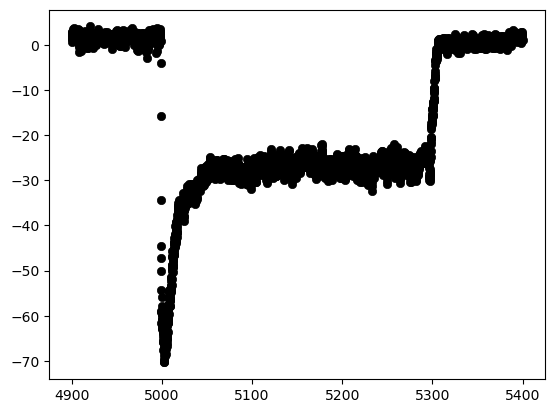

<re.Match object; span=(0, 10), match='2023_07_21'>
2023_07_21
12
57.98693648


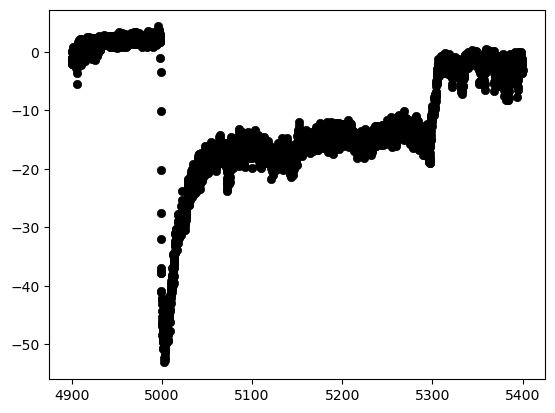

<re.Match object; span=(0, 10), match='2023_07_21'>
2023_07_21
16
38.10852026


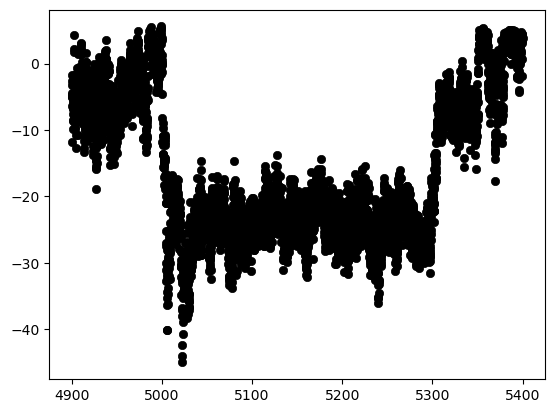

<re.Match object; span=(0, 10), match='2023_07_21'>
2023_07_21
3
22.78806351


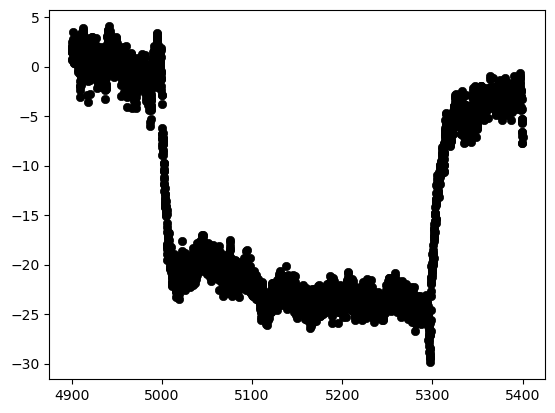

<re.Match object; span=(0, 10), match='2023_07_24'>
2023_07_24
13
61.3241545


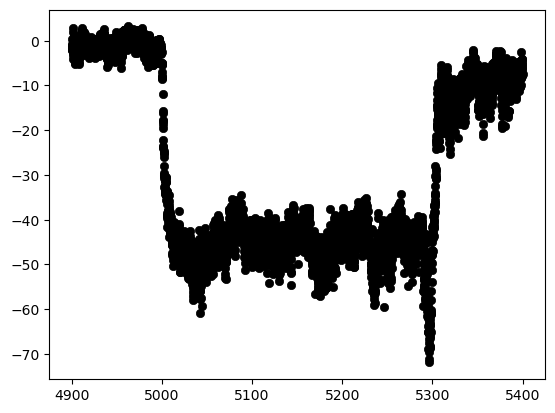

<re.Match object; span=(0, 10), match='2023_07_24'>
2023_07_24
25
47.04975756


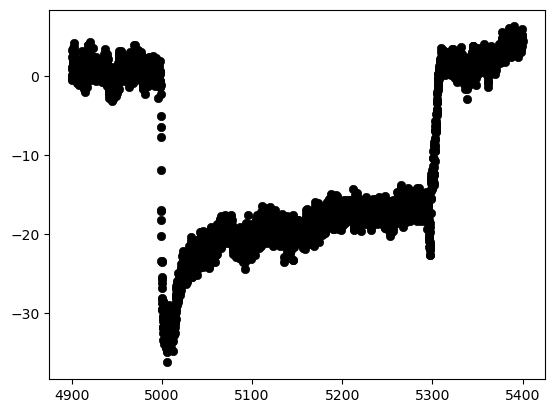

<re.Match object; span=(0, 10), match='2023_07_24'>
2023_07_24
26
36.0382113


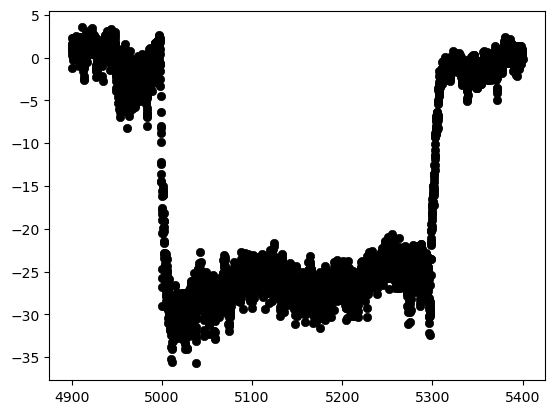

<re.Match object; span=(0, 10), match='2023_07_24'>
2023_07_24
34
29.49103017


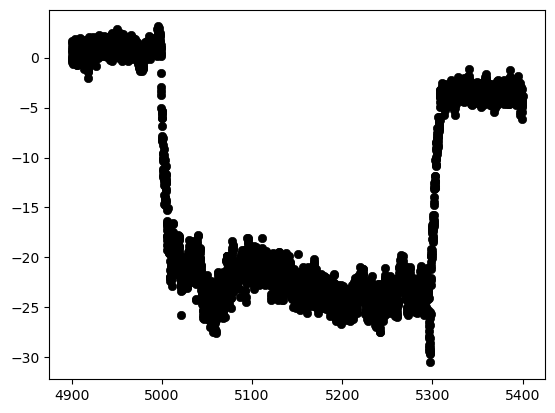

<re.Match object; span=(0, 10), match='2023_07_24'>
2023_07_24
42
not present
<re.Match object; span=(0, 10), match='2023_07_24'>
2023_07_24
9
28.04089061


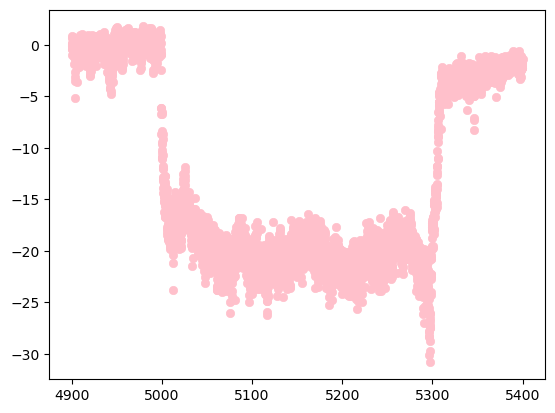

In [29]:
#generating traces figures
# date=
# number
# file=''

linecolor_dict= {'hPz1': 'gold', 'hPz2': 'pink', 'loaded': '#D5CAFF', 'blank': 'purple', 'var1s': 'black'}


directory = 'Z:/All_Staff/Grandl Lab/Michael Sindoni/mem_imaging_project/Pz1_Pz2_splice_expt/stretch_ascii_files/done'
for filename in os.listdir(directory):
    #loading individual ascii files
    df_ephys = load_dataframe(directory+'/'+filename)
    
    #using regular expression to pull out date and number
    date_pattern = r"\d{4}_\d{2}_\d{2}"
    time_pattern = r"\d{1,2}(?=\.)"
    date_match = re.search(date_pattern, filename)
    time_match = re.search(time_pattern, filename)
    print(date_match)
    if date_match and time_match:
        date_part = date_match.group()
        time_part = time_match.group()
        print(date_part)
        print(time_part)
    else:
        print("No match found.")

    #determining last sweep number from summary data df
    max_sweep=df_piezos['sweep'].loc[(df_piezos['date']==date_part) & (df_piezos['number']==float(time_part))].max()

    if math.isnan(max_sweep):
        print('not present')
        continue
    else:
        #only analyzing traces that have a plateau current >20pA
        if df_piezos['p50_avg_max_current'].loc[(df_piezos['date']==date_part) & (df_piezos['number']==float(time_part))].iloc[0]>20:
            print(df_piezos['p50_avg_max_current'].loc[(df_piezos['date']==date_part) & (df_piezos['number']==float(time_part))].iloc[0])
            
            #determining last sweep number from summary data df
            max_sweep=df_piezos['sweep'].loc[(df_piezos['date']==date_part) & (df_piezos['number']==float(time_part))].max()

            #pulling out raw ephys data for the last sweep with
            last_sweep_ephys=df_ephys.loc[df_ephys['sweep']==max_sweep]
            #determining the category of channel
            category=str(df_piezos['category'].loc[(df_piezos['date']==date_part) & (df_piezos['number']==float(time_part))].iloc[0])

            #isolating range to see pressure step current
            cut_last_sweep=last_sweep_ephys.loc[(last_sweep_ephys['ti']>=4900) & (last_sweep_ephys['ti']<=5400)]
            plt.scatter(cut_last_sweep['ti'], cut_last_sweep['i'], color=linecolor_dict[str(category)], linewidth=0.5)
            plt.show()
        else:
            print(date_part, time_part, 'not above 20pA')

In [ ]:
def fit_boltz(x, x0, k):
    y = 1 / (1 + np.exp(-k*(x-x0)))
    return y

grouped = df_pz1.groupby(['date', 'number'])
pz1_tension_list = []
pz1_cat_list = []
for name, group in grouped:
    floor_tension = group['tension']
    try:
        popt, pcov = curve_fit(fit_boltz, floor_tension, group['avg_norm_current'])
        pz1_tension_list.append(popt[1])
        pz1_cat_list.append('mPz1')
        print(popt[1])
    except RuntimeError as e:
        print(f"Runtime error occurred for {name}, {group}: {e}")
        continue

grouped = df_pz2.groupby(['date', 'number'])
pz2_tension_list = []
pz2_cat_list = []
for name, group in grouped:
    floor_tension = group['tension']
    try:
        popt, pcov = curve_fit(fit_boltz, floor_tension, group['avg_norm_current'])
        pz2_tension_list.append(popt[1])
        pz2_cat_list.append('COhPz2')
    except RuntimeError as e:
        print(f"Runtime error occurred for {name}, {group}: {e}")
        continue

tension = pz1_tension_list + pz2_tension_list
cats = pz1_cat_list + pz2_cat_list
df_tensions = pd.DataFrame({'tension': tension, 'category': cats})

fig, ax = plt.subplots(figsize=(3, 5))
sns.stripplot(data=df_tensions, x='category', y='tension', ax=ax, s=10, palette=['lightblue', 'magenta'])
PROPS = {
    'boxprops': {'facecolor': 'none', 'edgecolor': 'white'},
    'medianprops': {'color': 'white'},
    'whiskerprops': {'color': 'white'},
    'capprops': {'color': 'white'}
}
sns.boxplot(data=df_tensions, x='category', y='tension', ax=ax, color='white', **PROPS, showfliers=False)

# ax.set_ylim(0,)
# ax.set_ylabel('k (T50 slope)', fontsize=15, color='white')
# ax.tick_params(axis='both', labelsize=15, color='white')
# ax.set_xlabel(None)
# ax.tick_params(axis='x', colors='white')
# ax.tick_params(axis='y', colors='white')
# ax.spines['bottom'].set_color('white')
# ax.spines['left'].set_color('white')


In [ ]:
fig, ax = plt.subplots()
sns.scatterplot(data=df_pz1, x='pressure', y='avg_norm_current', hue=df_pz1[['date', 'number']].apply(tuple, axis=1), 
                ax=ax, legend=False, s=50, palette='spring')


ax.set_xlabel('Pressure (mmHg)', fontsize=15, color='white')
ax.set_ylabel('Normalized Current', fontsize=15, color='white')
ax.tick_params(axis='both', labelsize=15, color='white')

ax.tick_params(axis='x', colors='white') 
ax.tick_params(axis='y', colors='white') 
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')


In [ ]:
#determine P50 and k for multiple patches
df_pz2=df_piezos.loc[(df_piezos['category']=='hPz2') & (df_piezos['tension']<12)]
pop_p50_fig=generate_T50_norm(df_pz2)

In [ ]:
#determine P50 and k for multiple patches
df_loaded=df_piezos.loc[(df_piezos['category']=='loaded') & (df_piezos['tension']<12)]
pop_p50_fig=generate_T50_norm(df_loaded)

In [ ]:
#determine P50 and k for multiple patches
df_blank=df_piezos.loc[(df_piezos['category']=='blank') & (df_piezos['tension']<12)]
pop_p50_fig=generate_T50_norm(df_blank)

In [ ]:
#plot the max current data and return a figure
max_i_plot_fig=gen_max_i_plot(df_piezos)

In [ ]:
#isolating max_i data into a plotable list
max_i_list=[]
cat_list=[]
grouped=df_piezos.groupby(['date', 'number'])
for name, group in grouped:
    max_i_list.append(group['avg_max_current'].max())
    cat_list.append(group['category'].iloc[1])



#creating identity for each dot for visualizing individual patches
unique_pairs = []  # List to store unique date/number pairs
for index, row in df_piezos.iterrows():
    date = row['date']
    number = row['number']
    pair = (date, number)  # Create a tuple of date/number pair

    if pair not in unique_pairs:
        unique_pairs.append(pair)  # Add unique pair to the list

#creating a dataframe to use for plotting in seaborn
df_maxi_graph=pd.DataFrame({'max_i':max_i_list,
                          'cat':cat_list,
                          'identity':unique_pairs})

#creating k plot
fig, ax=plt.subplots(figsize=(3, 5))
sns.stripplot(data=df_maxi_graph, x='cat', y='max_i', hue='identity', palette = 'RdYlBu', s = 10,
              ax=ax, edgecolor='black', linewidth=1)

#creating a boxplot that is transparent but still shows the black outline
PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'Black'},
    'medianprops':{'color':'Black'},
    'whiskerprops':{'color':'Black'},
    'capprops':{'color':'Black'}
}
sns.boxplot(data=df_maxi_graph, x='cat', y='max_i', ax=ax,**PROPS)
ax.set(xlabel=None)
#removing the top and right border
sns.despine(top=True, right=True, left=False, bottom=False, ax=ax)
ax.set_ylim(0, max(max_i_list)+10)
ax.set_ylabel('Max Current (pA)') #add y axis title
ax.get_legend().remove()


In [ ]:
#determine P50 and k for multiple patches
df_hPz1=df_piezos.loc[(df_piezos['category']=='hPz1') & (df_piezos['p50_avg_max_current']>30)]
pop_p50_fig=generate_p50_multiple(df_hPz1)

In [ ]:
#determine P50 and k for multiple patches
df_hPz2=df_piezos.loc[(df_piezos['category']=='hPz2') & (df_piezos['p50_avg_max_current']>30)]
pop_p50_fig=generate_p50_multiple(df_hPz2)

In [ ]:
#determine P50 and k for multiple patches
df_loaded=df_piezos.loc[(df_piezos['category']=='loaded') & (df_piezos['p50_avg_max_current']>50)]
pop_p50_fig=generate_p50_multiple(df_loaded)

In [ ]:
#determine P50 and k for multiple patches
df_blank=df_piezos.loc[(df_piezos['category']=='blank') & (df_piezos['p50_avg_max_current']>30)]
pop_p50_fig=generate_p50_multiple(df_blank)

In [ ]:
current_cut=df_piezos.loc[df_piezos['p50_avg_max_current']>30]
#isolating max_i data into a plotable list
max_i_list=[]
cat_list=[]
grouped=current_cut.groupby(['date', 'number'])
for name, group in grouped:
    max_i_list.append(group['avg_max_current'].max())
    cat_list.append(group['category'].iloc[1])



#creating identity for each dot for visualizing individual patches
unique_pairs = []  # List to store unique date/number pairs
for index, row in current_cut.iterrows():
    date = row['date']
    number = row['number']
    pair = (date, number)  # Create a tuple of date/number pair

    if pair not in unique_pairs:
        unique_pairs.append(pair)  # Add unique pair to the list

#creating a dataframe to use for plotting in seaborn
df_maxi_graph=pd.DataFrame({'max_i':max_i_list,
                          'cat':cat_list,
                          'identity':unique_pairs})

#creating k plot
fig, ax=plt.subplots(figsize=(3, 5))
sns.stripplot(data=df_maxi_graph, x='cat', y='max_i', hue='identity', palette = 'RdYlBu', s = 10,
              ax=ax, edgecolor='black', linewidth=1)

#creating a boxplot that is transparent but still shows the black outline
PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'Black'},
    'medianprops':{'color':'Black'},
    'whiskerprops':{'color':'Black'},
    'capprops':{'color':'Black'}
}
sns.boxplot(data=df_maxi_graph, x='cat', y='max_i', ax=ax,**PROPS)
ax.set(xlabel=None)
#removing the top and right border
sns.despine(top=True, right=True, left=False, bottom=False, ax=ax)
ax.set_ylim(0, max(max_i_list)+10)
ax.set_ylabel('Max Current (pA)') #add y axis title
ax.get_legend().remove()
